In [1]:
import sklearn as skl
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import math
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import janitor
import cairo
import random
import re
import collections
import networkx as nx
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from collections import namedtuple
from random import randint

In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
Point = collections.namedtuple('Point', 'x y')

In [4]:
df = pd.read_excel('DataVisualizationV5.xlsx', sheet_name='QualitySheet')
pf = pd.read_excel('DataVisualizationV5.xlsx', sheet_name='PhaseSheet')
ss = pd.read_excel('DataVisualizationV5.xlsx', sheet_name='SizeSpec')
ds = pd.read_excel('DataVisualizationV5.xlsx', sheet_name='SequenceSheet')
ess = pd.read_excel('DataVisualizationV5.xlsx', sheet_name='EntireSequenceSheet')

In [5]:
jitteredDf = df.copy()
sample = df.copy()
sample = sample.drop(columns=['Quality'])

In [6]:
sample = sample.columns.values.tolist()

In [7]:
for f in sample:
    jitteredDf.jitter(
        column_name=f,
        dest_column_name=f,
        scale=0.5,
        clip=None,
        random_state=None
    )

In [8]:
meltedPhases = pf.melt('Procedures', var_name='Instruments')

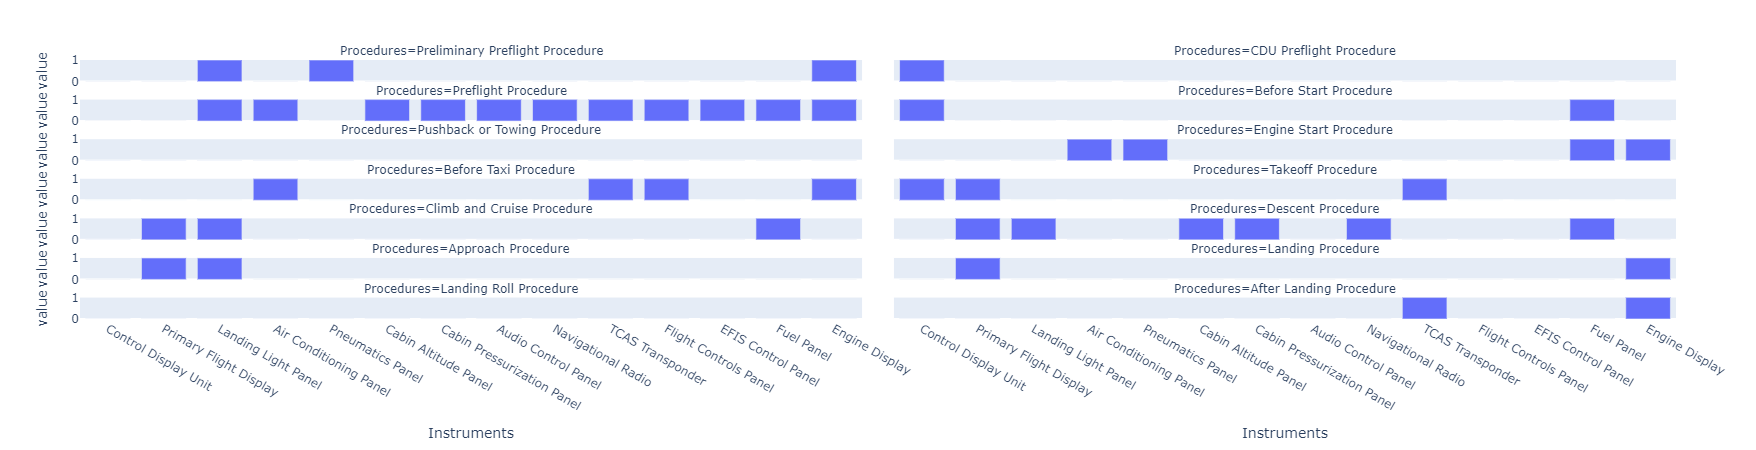

In [9]:
fig = px.bar(meltedPhases, x="Instruments", y="value",
             facet_col="Procedures",
            facet_col_wrap=2)
fig.update_yaxes(range=[0,1])
fig.update_yaxes(nticks=2)
fig.show()

In [10]:
meltedDf = df.melt('Quality', var_name='Instruments')

In [11]:
jitteredMelt = jitteredDf.melt('Quality', var_name='Instruments')

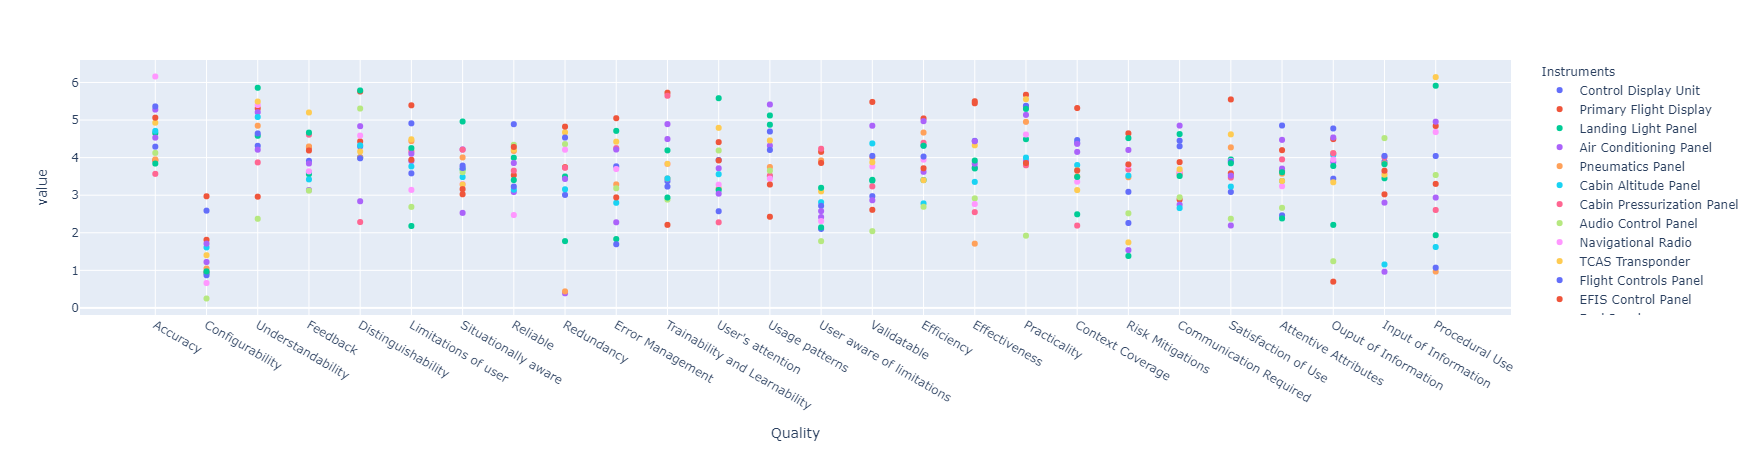

In [12]:
fig = px.scatter(jitteredMelt, x="Quality", y="value", color="Instruments")
fig.show()

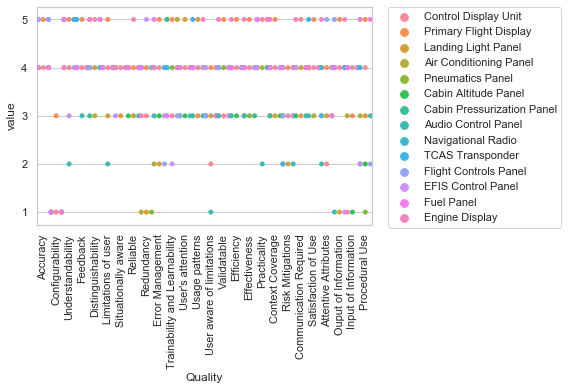

In [13]:
y = [1, 2, 3, 4, 5]
yint = range(min(y), math.ceil(max(y))+1)
sns.set(style="whitegrid", color_codes=True)
g = sns.swarmplot(x="Quality", y="value", hue='Instruments', data=meltedDf)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.rcParams['figure.figsize'] = [25, 25]
plt.yticks(yint)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [14]:
def getColPalette():
    hex_colors_dic = {}
    rgb_colors_dic = {}
    hex_colors_only = []
    for name, hex in mpl.colors.cnames.items():
        hex_colors_only.append(hex)
        hex_colors_dic[name] = hex
        rgb_colors_dic[name] = mpl.colors.to_rgb(hex)
    return random.choice(hex_colors_only)

In [15]:
def printRadarPlots(dataDF, colName):
    ## Since we are using DF which is un-edited at this point in the program, I am going to assume that the Quality column is in the dataFrame
    fig = make_subplots(rows=1, cols=1, specs=[[{"type": "polar"}]])
    fig.add_trace(go.Scatterpolar(
        name=colName,
        r=dataDF[colName],
        theta=dataDF['Quality'],
        marker_color = getColPalette(),
        fill='toself'
        ), 1, 1)
    fig.update_layout(height=500, width=500, title_text=colName)
    fig.show()

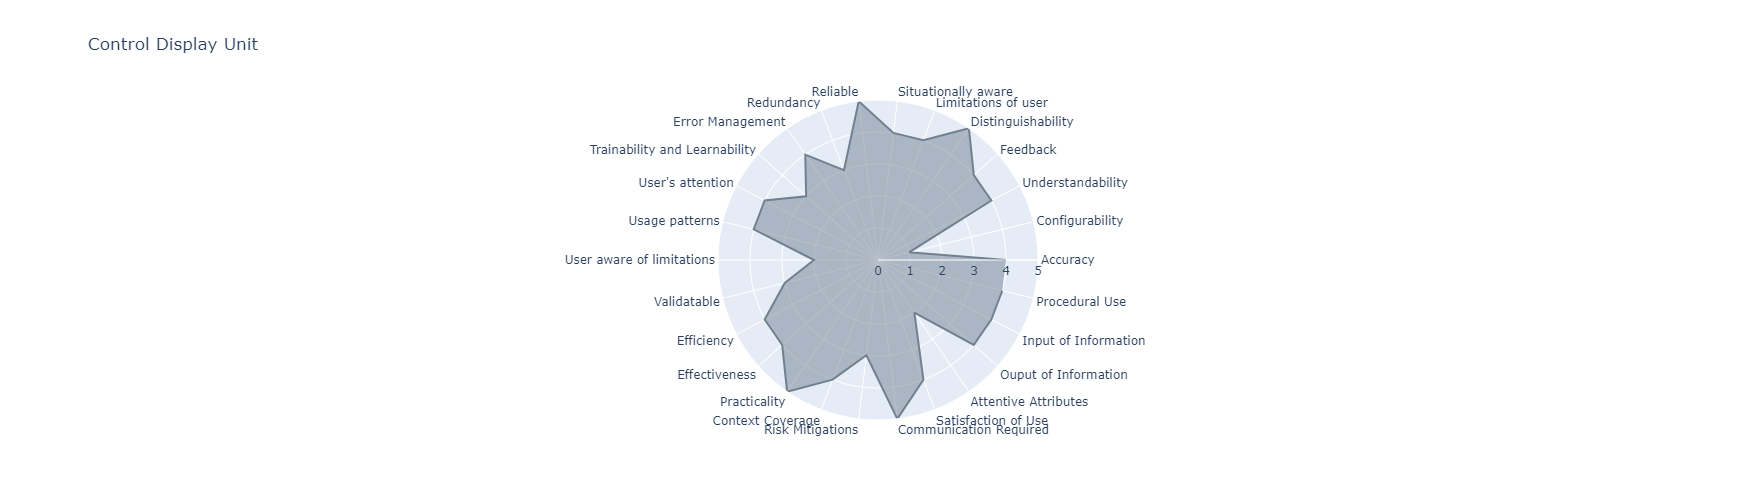

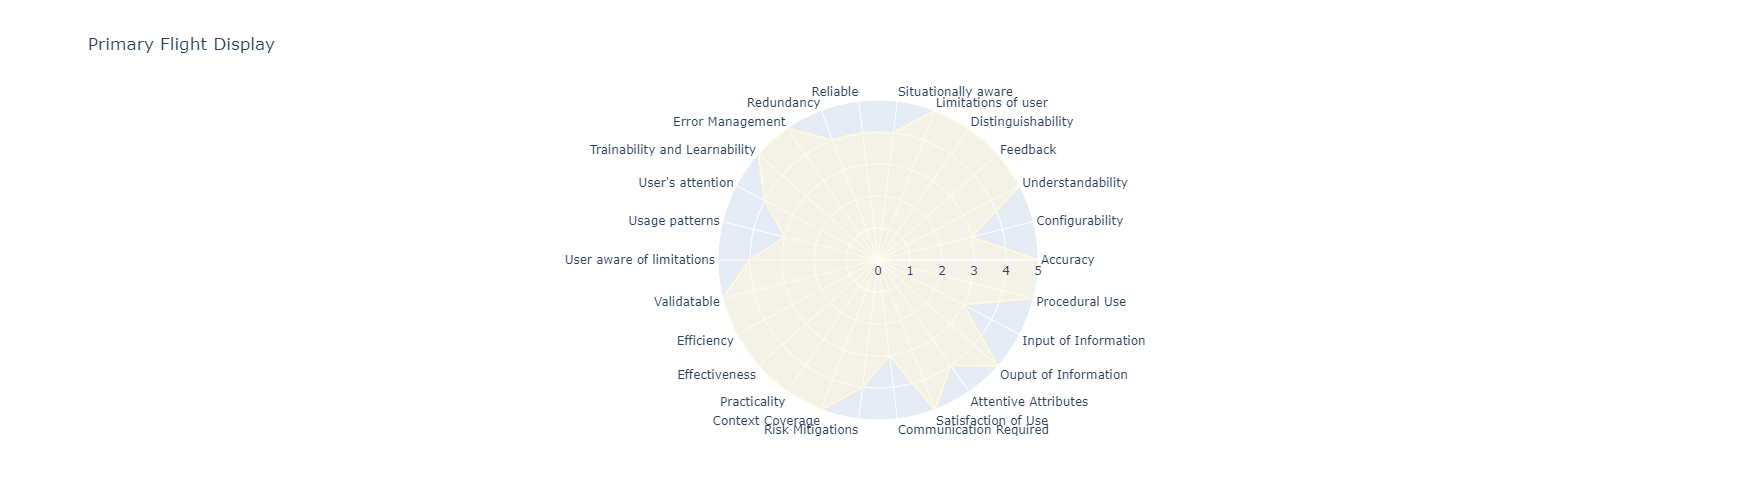

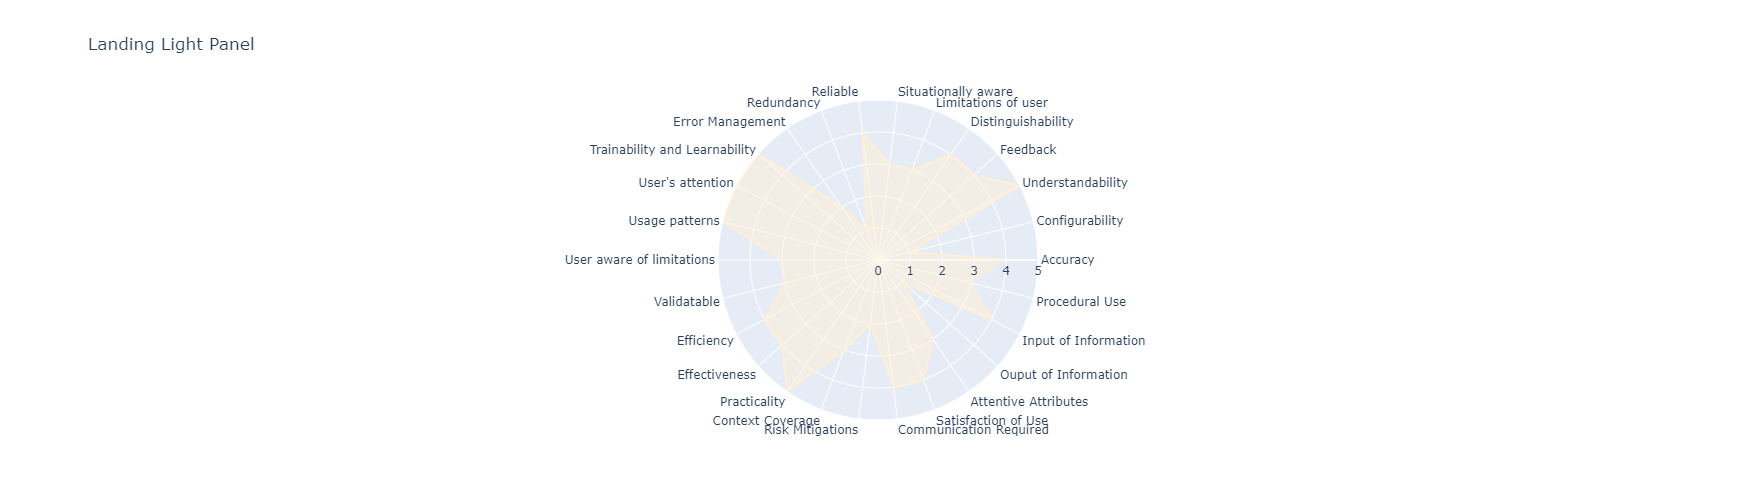

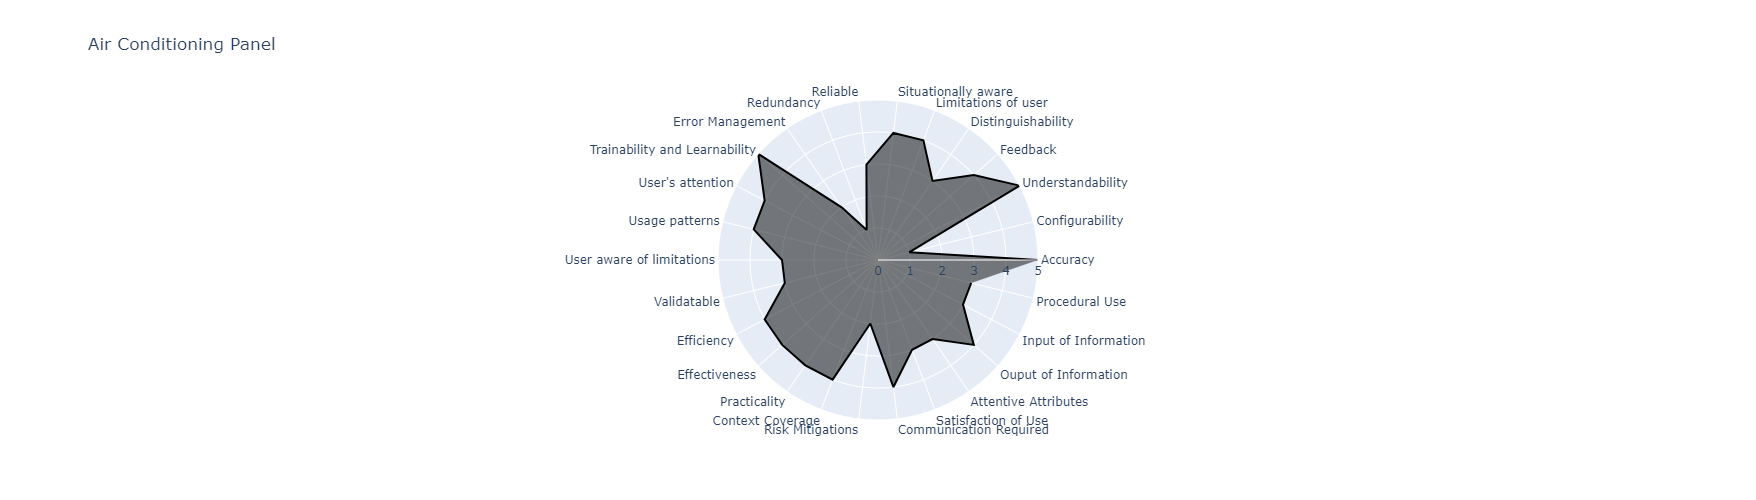

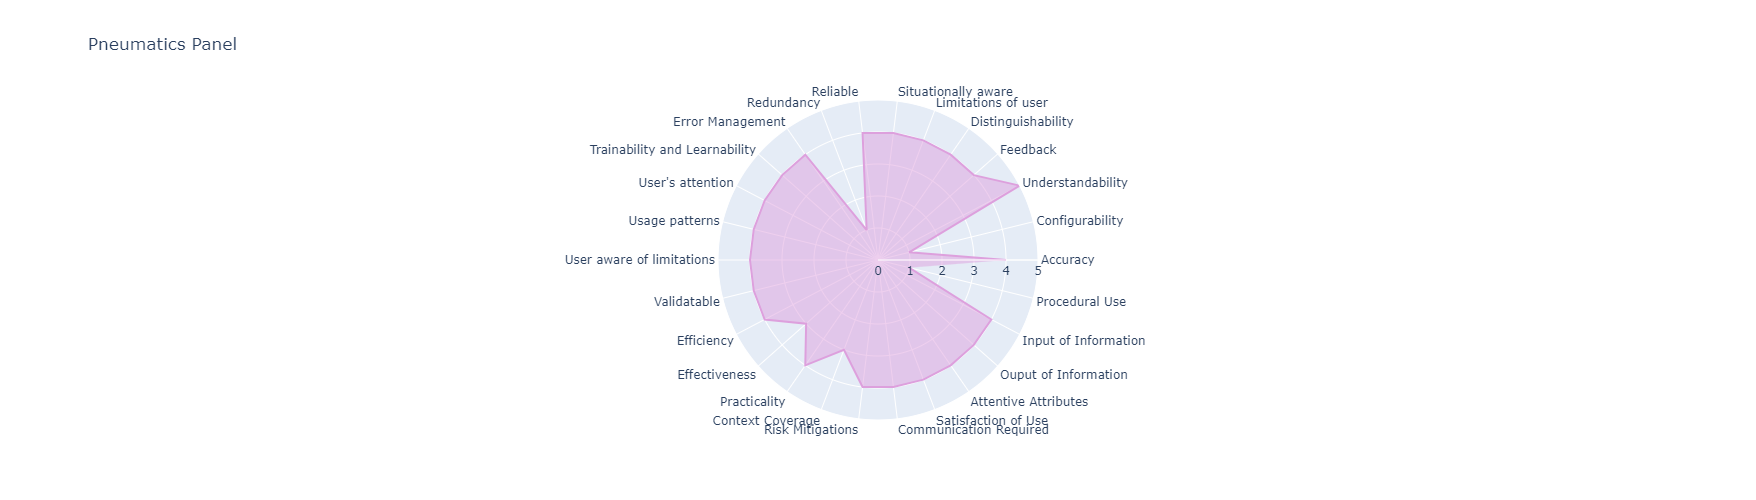

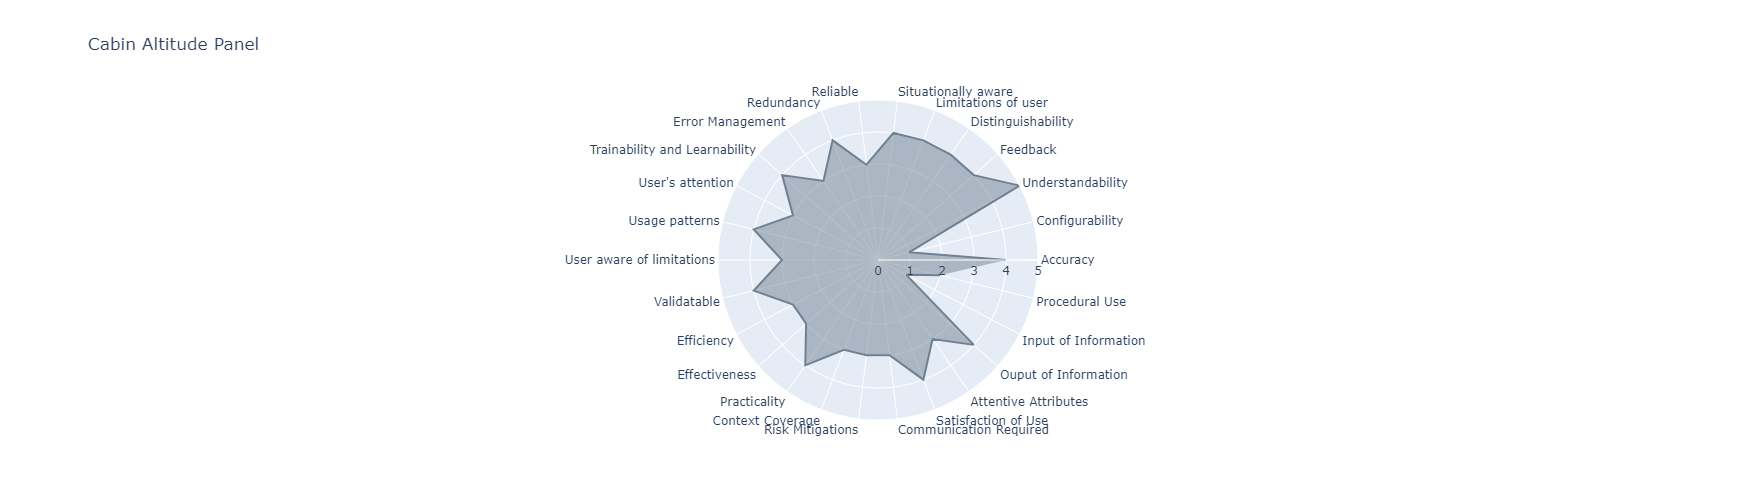

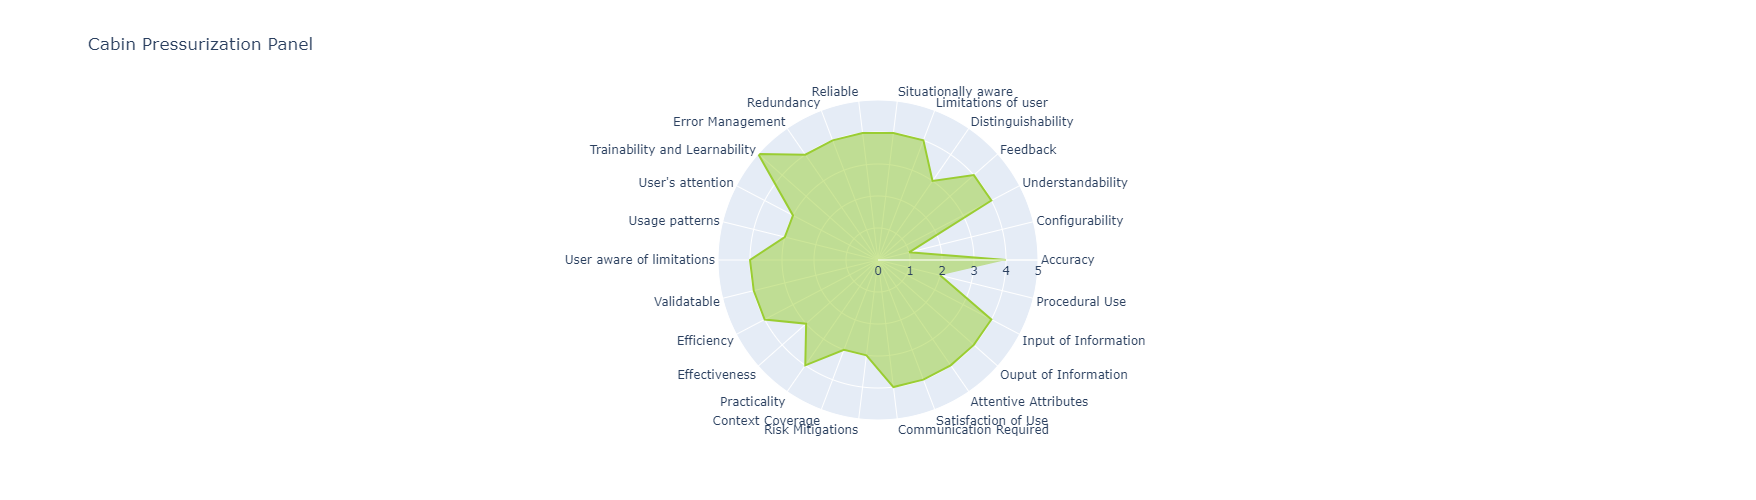

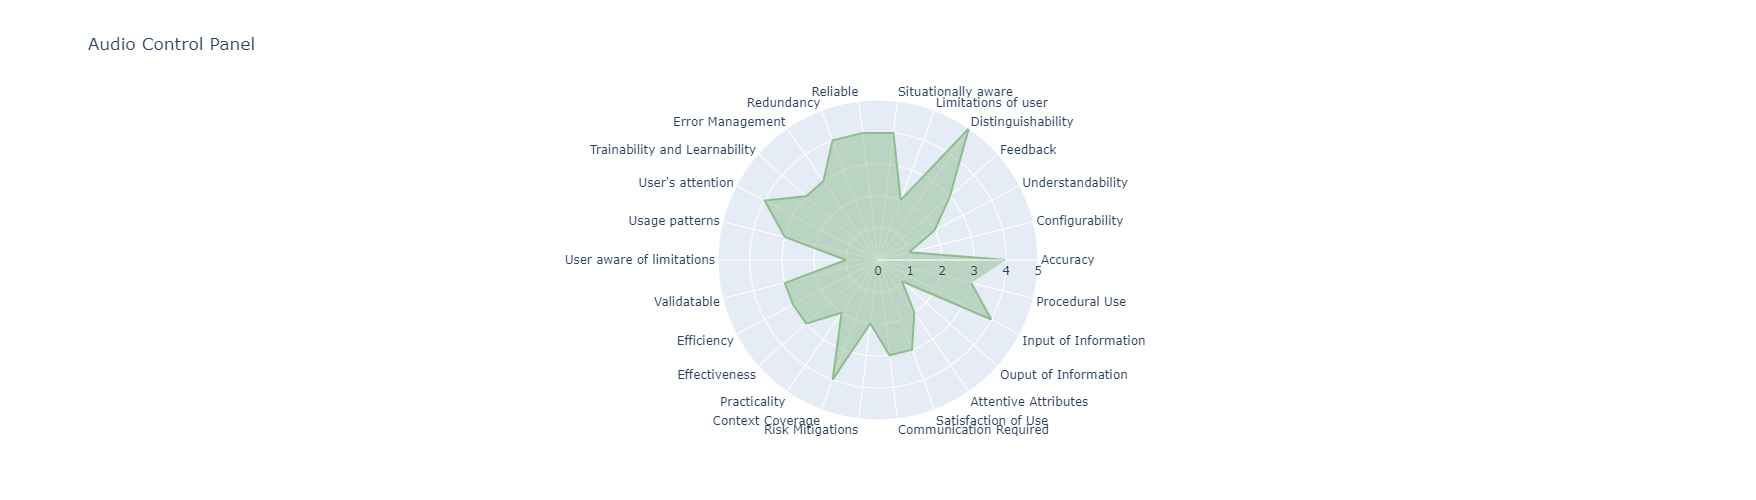

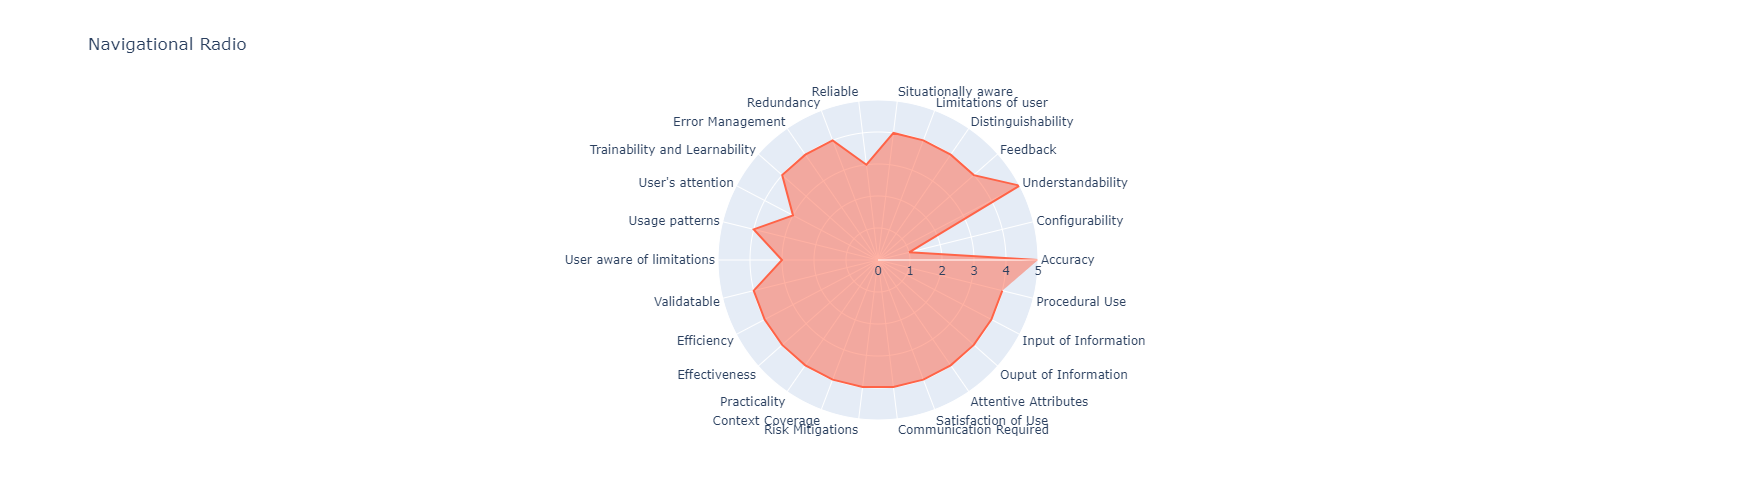

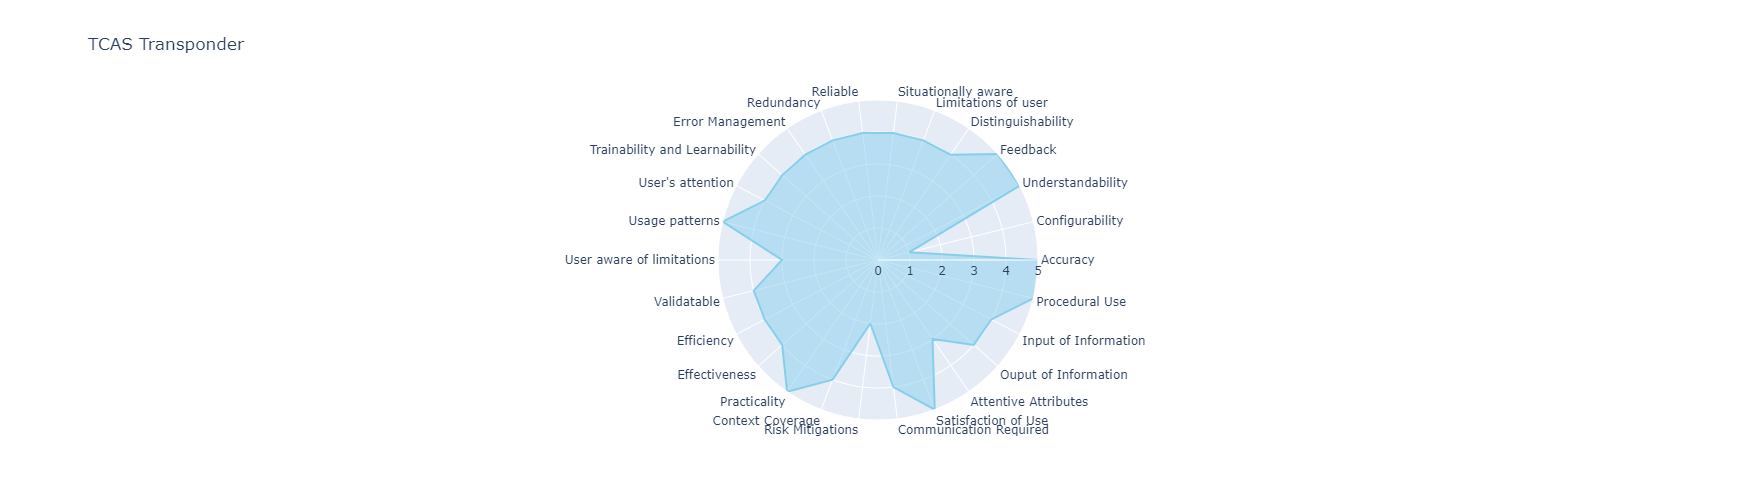

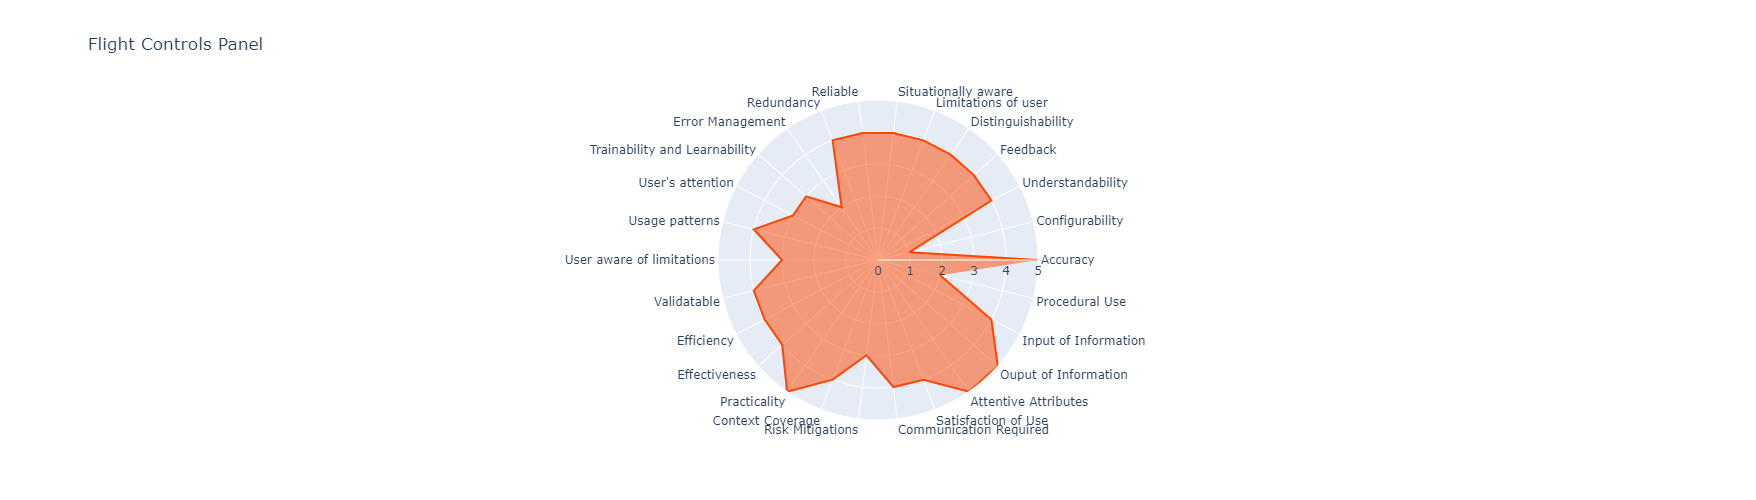

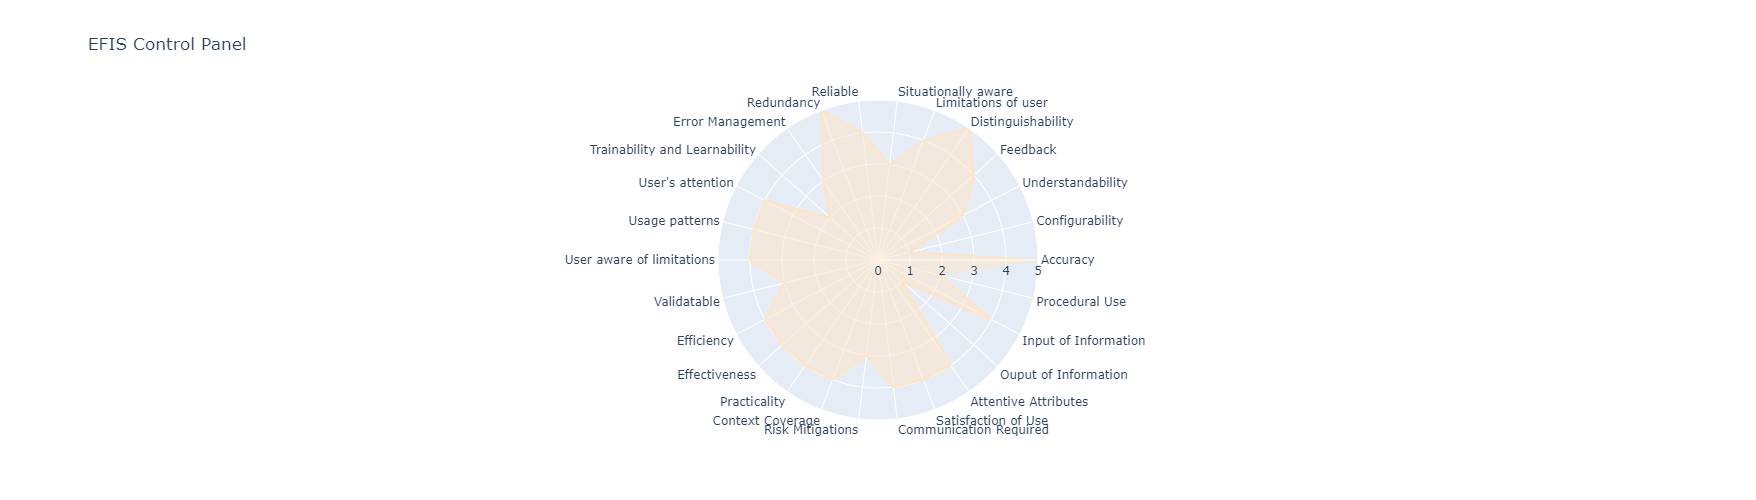

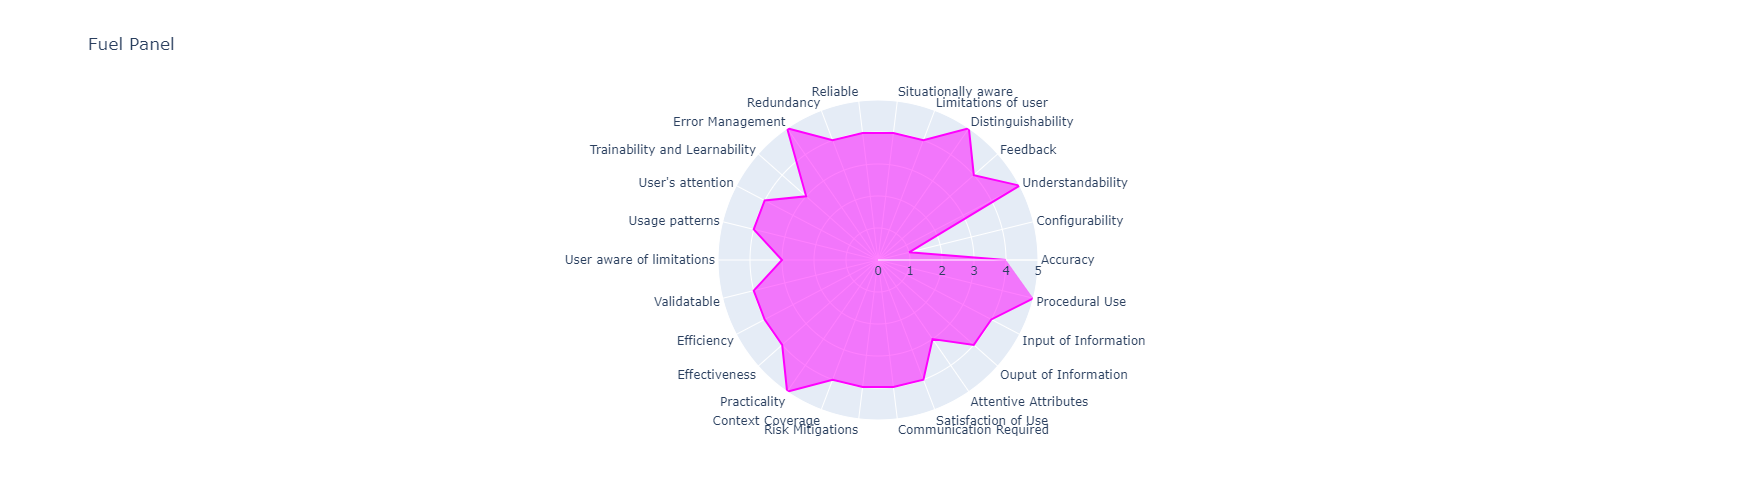

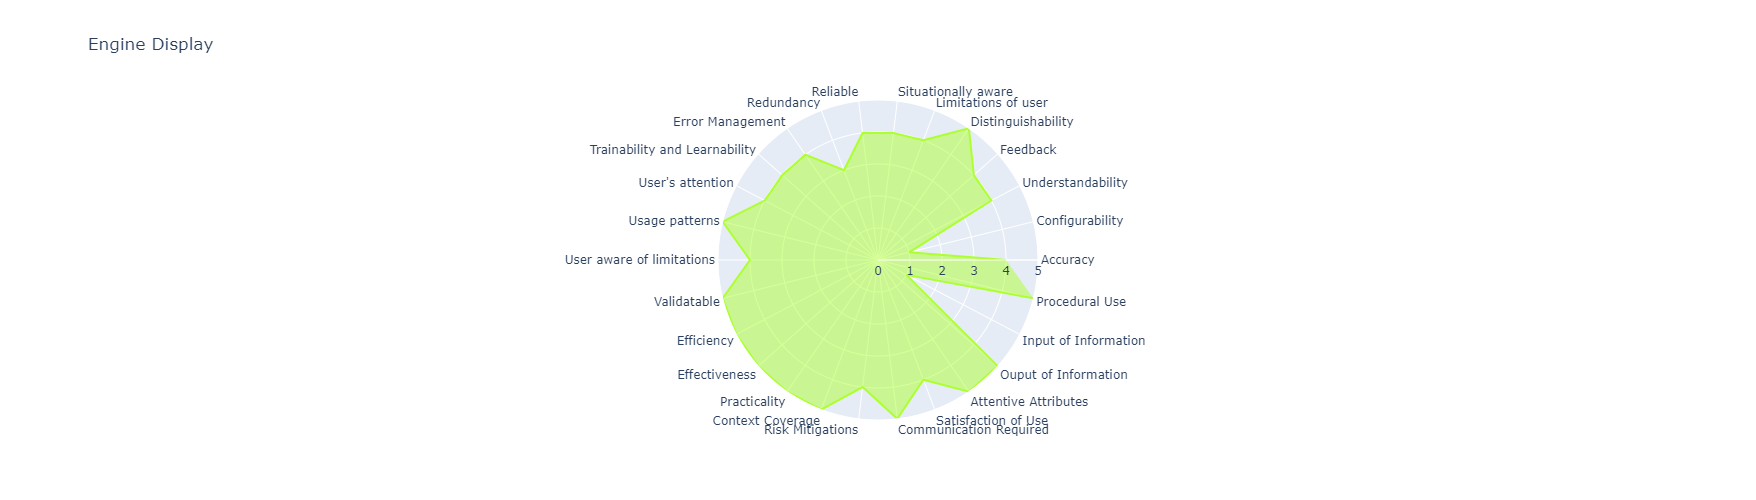

In [16]:
for col in df.columns:
    if col != 'Quality':
        printRadarPlots(df, col)

In [17]:
X = jitteredDf.iloc[:,1:].values

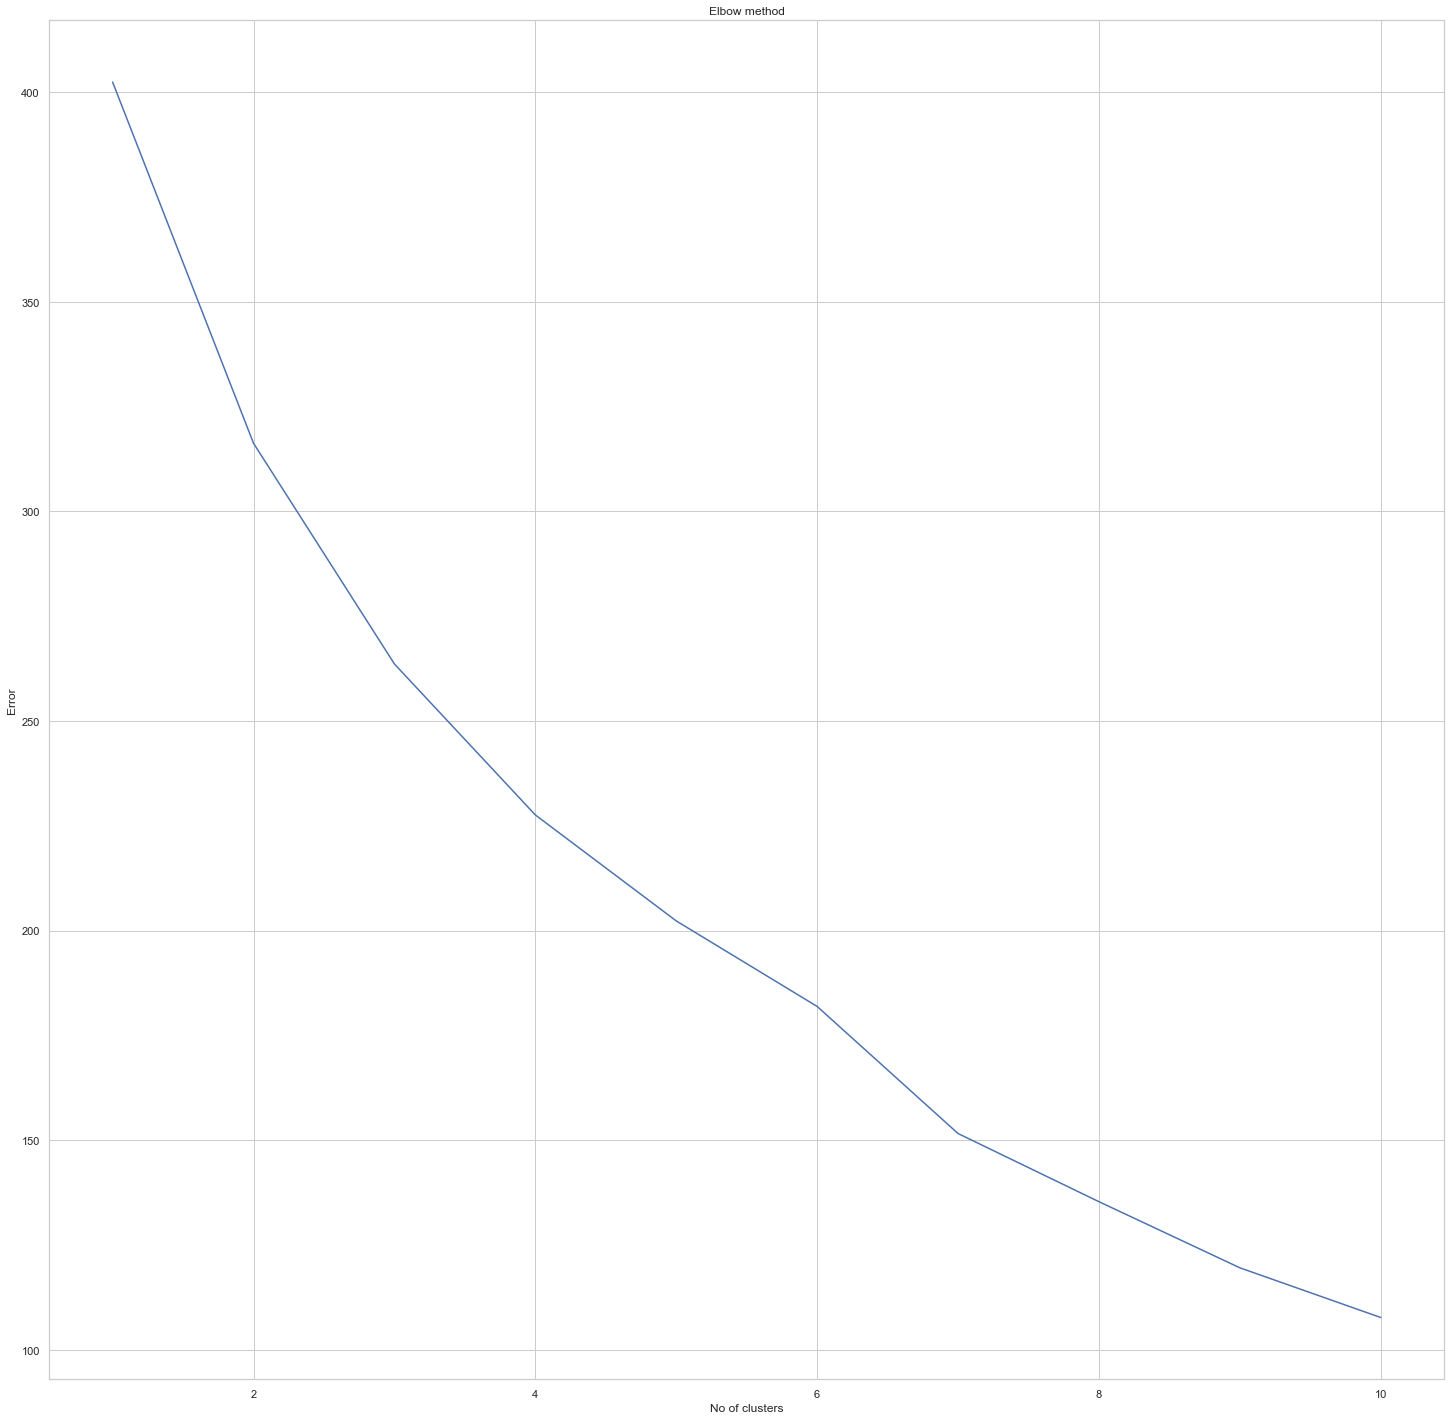

In [18]:
## Elbow method
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(X)
    kmeans.fit(X)
    Error.append(kmeans.inertia_)
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [19]:
kPro = KPrototypes(n_clusters=3, max_iter=600, n_init=50, init='Cao')

In [20]:
kResult = kPro.fit_predict(jitteredDf, categorical=[0])

In [21]:
jitteredDf['Clusters'] = kResult

In [22]:
jitteredMelt2 = pd.melt(jitteredDf, id_vars=['Quality', 'Clusters'], var_name='Instruments')

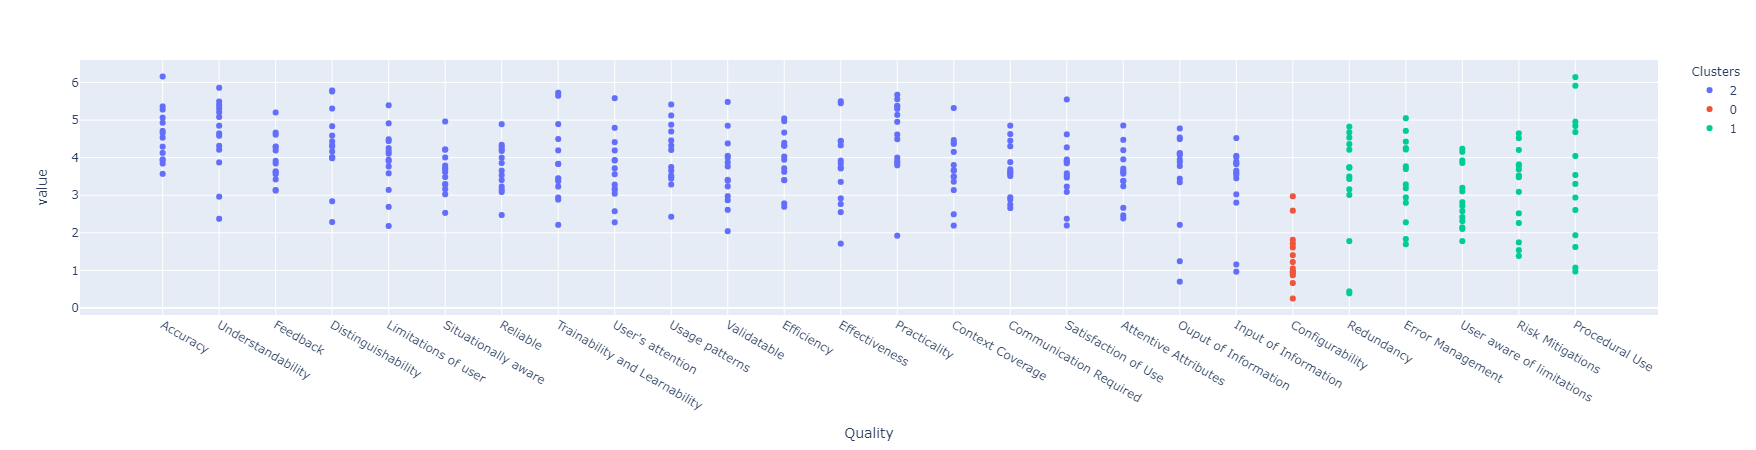

In [23]:
fig = px.scatter(jitteredMelt2, x="Quality", y="value", color="Clusters")
fig.show()

In [24]:
def drawDetailedUndirectedGraphs(ds):
    for index in ds.index.values:
        tempGraph = nx.Graph()
        frames = ds.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        tempGraph.add_nodes_from(frames.index.values)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
        plt.rcParams['figure.figsize'] = [5, 5]
        labels = nx.get_edge_attributes(tempGraph,'weight')
        nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
        nx.draw_circular(tempGraph, with_labels=True)
        plt.draw()
        plt.show()

In [25]:
def drawDetailedDirectedGraphs(ds):
    for index in ds.index.values:
        tempGraph = nx.DiGraph()
        frames = ds.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        tempGraph.add_nodes_from(frames.index.values)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
        plt.rcParams['figure.figsize'] = [5, 5]
        nx.draw_circular(tempGraph, with_labels=True)
        labels = nx.get_edge_attributes(tempGraph,'weight')
        nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
        plt.draw()
        plt.show()

In [26]:
def drawFullDetailedUndirectedGraphs(ds):
    tempGraph = nx.Graph()
    tempGraph.add_nodes_from(ds.columns)
    for index in ds.index.values:
        frames = ds.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()

In [27]:
def drawFullDetailedDirectedGraphs(ds):
    tempGraph = nx.DiGraph()
    tempGraph.add_nodes_from(ds.columns)
    for index in ds.index.values:
        frames = ds.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
            else:
                tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()

In [28]:
def getFirst(frames):
    iterator = frames[frames == 1].index.values
    if len(iterator) == 0:
        return findIndexUsingNum(frames, 1)
    else:
        return iterator[0]

In [29]:
def getSize(frame):
    size = frame.size
    for f in frame:
        if(type(f) == np.str):
            for c in f:
                if(c == ','):
                    size+=1
    return size

In [30]:
def comCheck(dataframe):
    comCount = 0
    for row in dataframe.index.values:
        rowFrame = dataframe.iloc[row]
        for f in rowFrame:
            if(type(f) == np.str):
                for c in f:
                    if(c == ','):
                        comCount+=1
    return comCount

In [31]:
def findIndexUsingNum(frames, number):
    for frame in frames:
        if(type(frame) == np.str):
            nums = re.findall('\d+', frame)
            nums = list(map(int, nums))
            if number in nums:
                 return frames[frames == frame].index.values[0]
    return None

In [32]:
## Drop column from ds
def dropProdCol(dataframe):
    if 'Procedures' in dataframe.columns:
        dataframe = dataframe.drop(columns=['Procedures'])
        return dataframe
    else:
        return dataframe

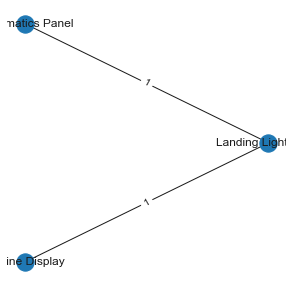

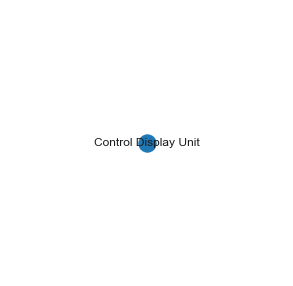

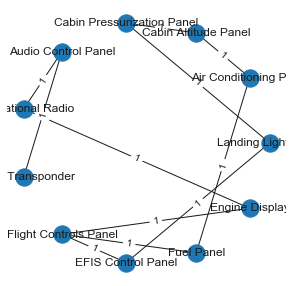

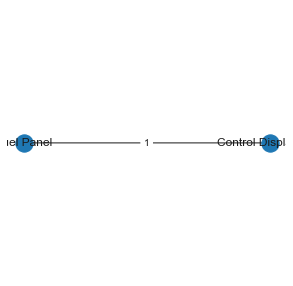

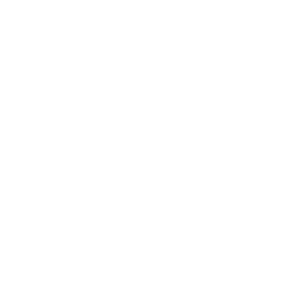

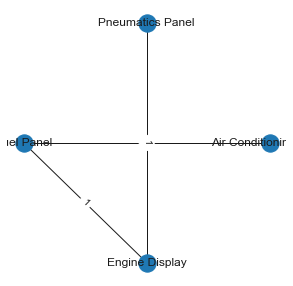

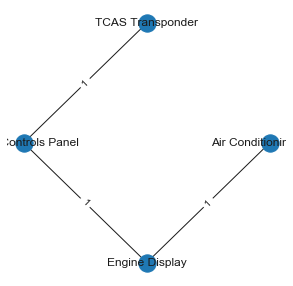

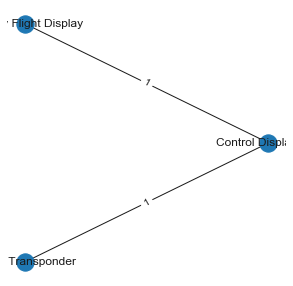

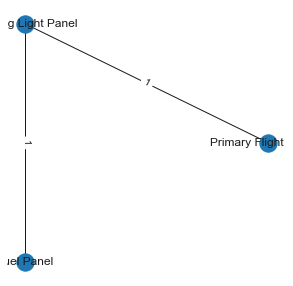

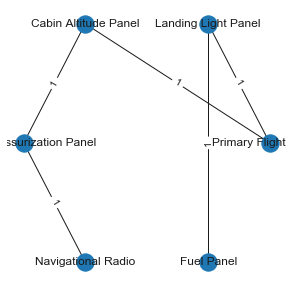

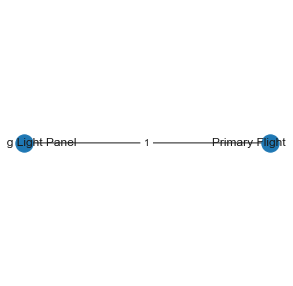

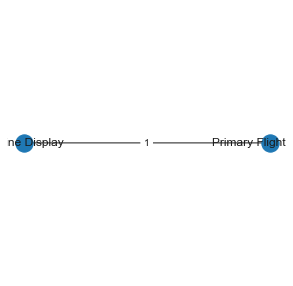

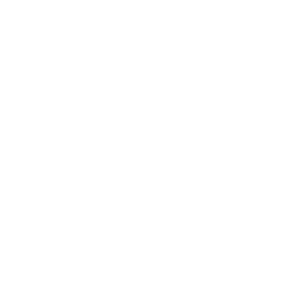

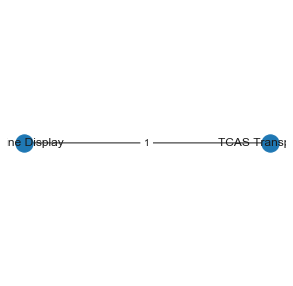

In [33]:
## Drawing them undirected but more detailed - one diagram for each phase
## This time the nodes which are connected are in sequence according to procedural use
ds = dropProdCol(ds)
drawDetailedUndirectedGraphs(ds)

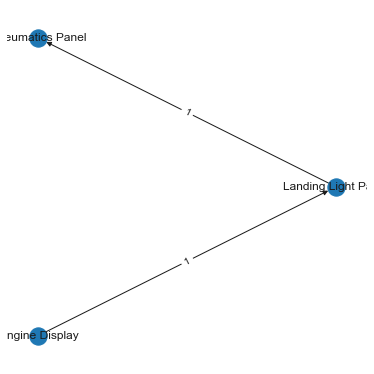

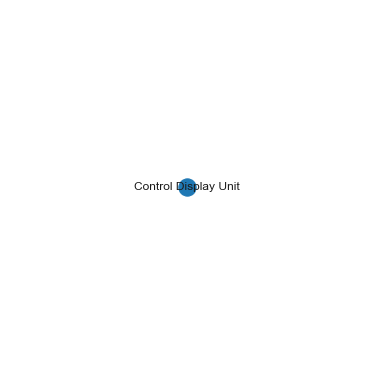

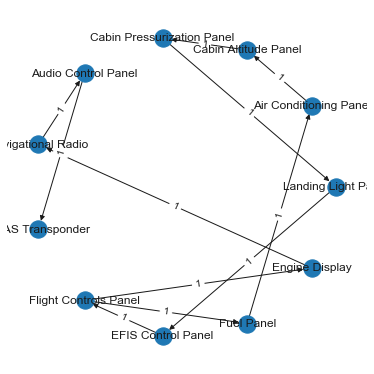

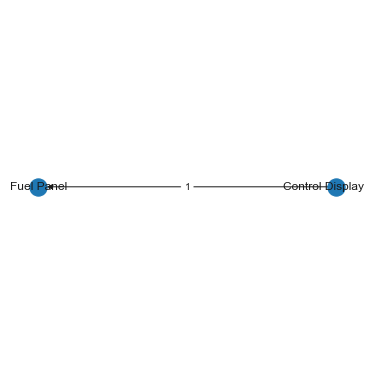

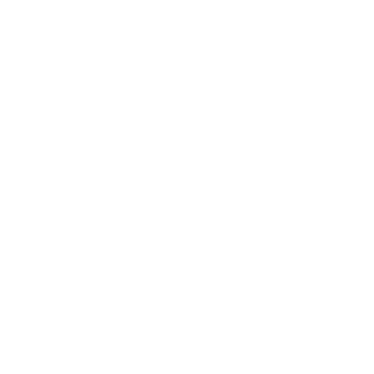

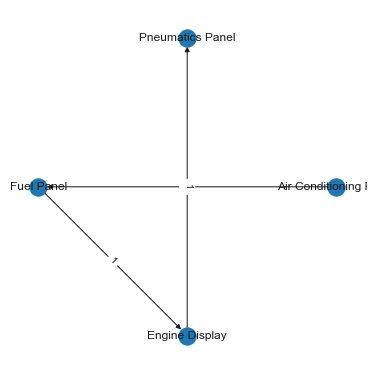

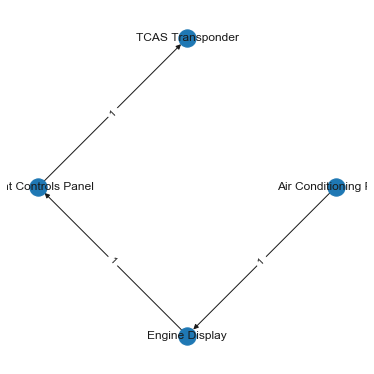

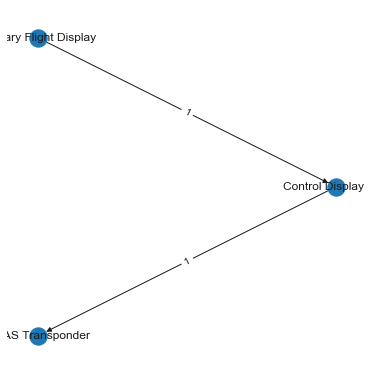

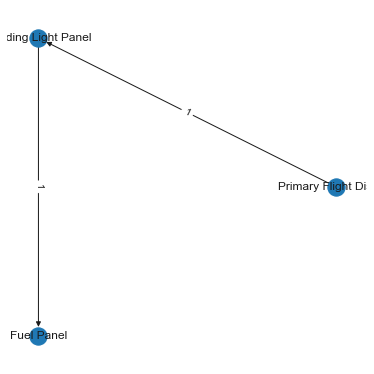

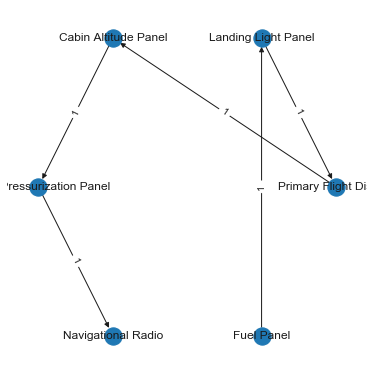

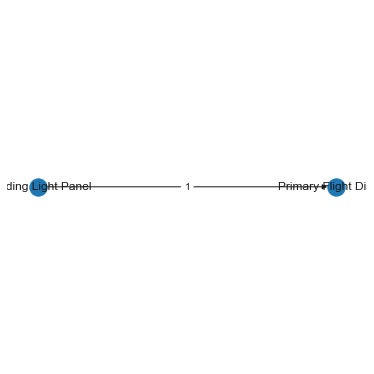

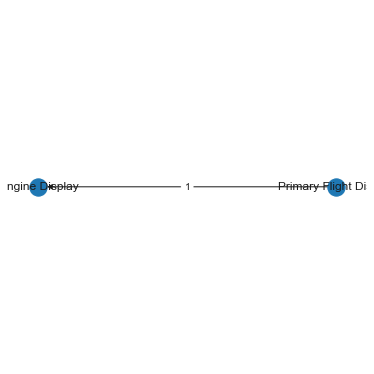

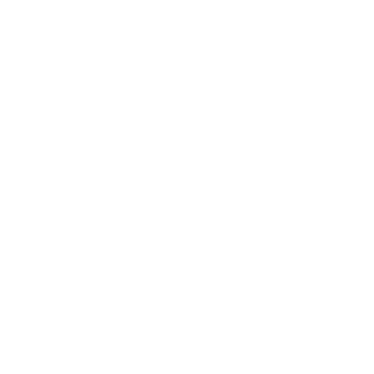

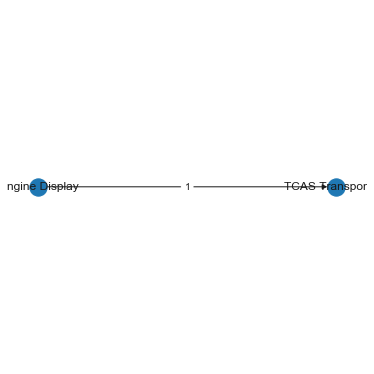

In [34]:
## Drawing them directed but more detailed - one diagram for each phase
## This time the nodes which are connected are in sequence according to procedural use
ds = dropProdCol(ds)
drawDetailedDirectedGraphs(ds)

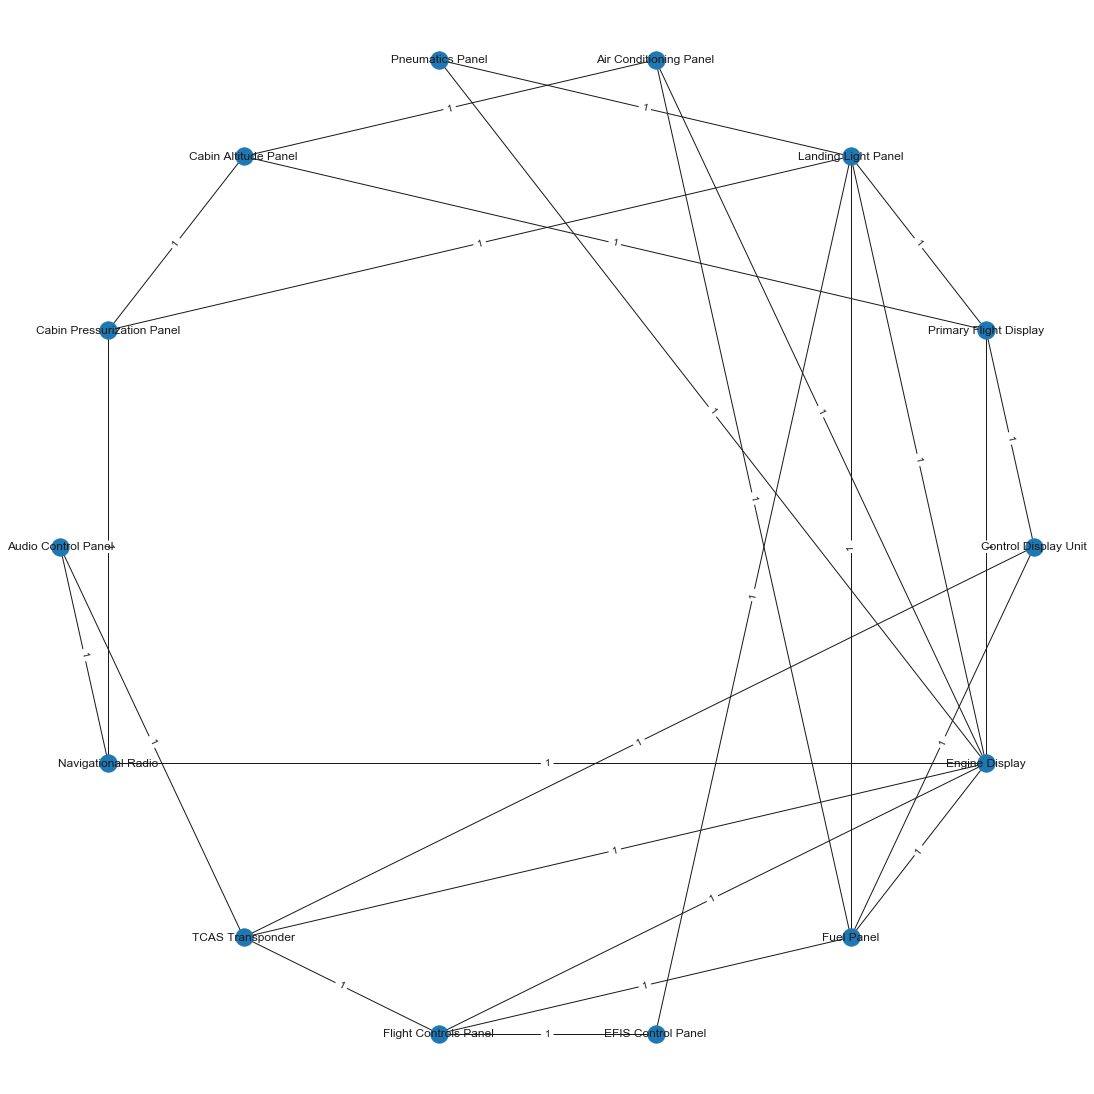

In [35]:
## Drawing full undirected graph - one large diagram
## ALl nodes are connected according to sequence only
ds = dropProdCol(ds)
drawFullDetailedUndirectedGraphs(ds)

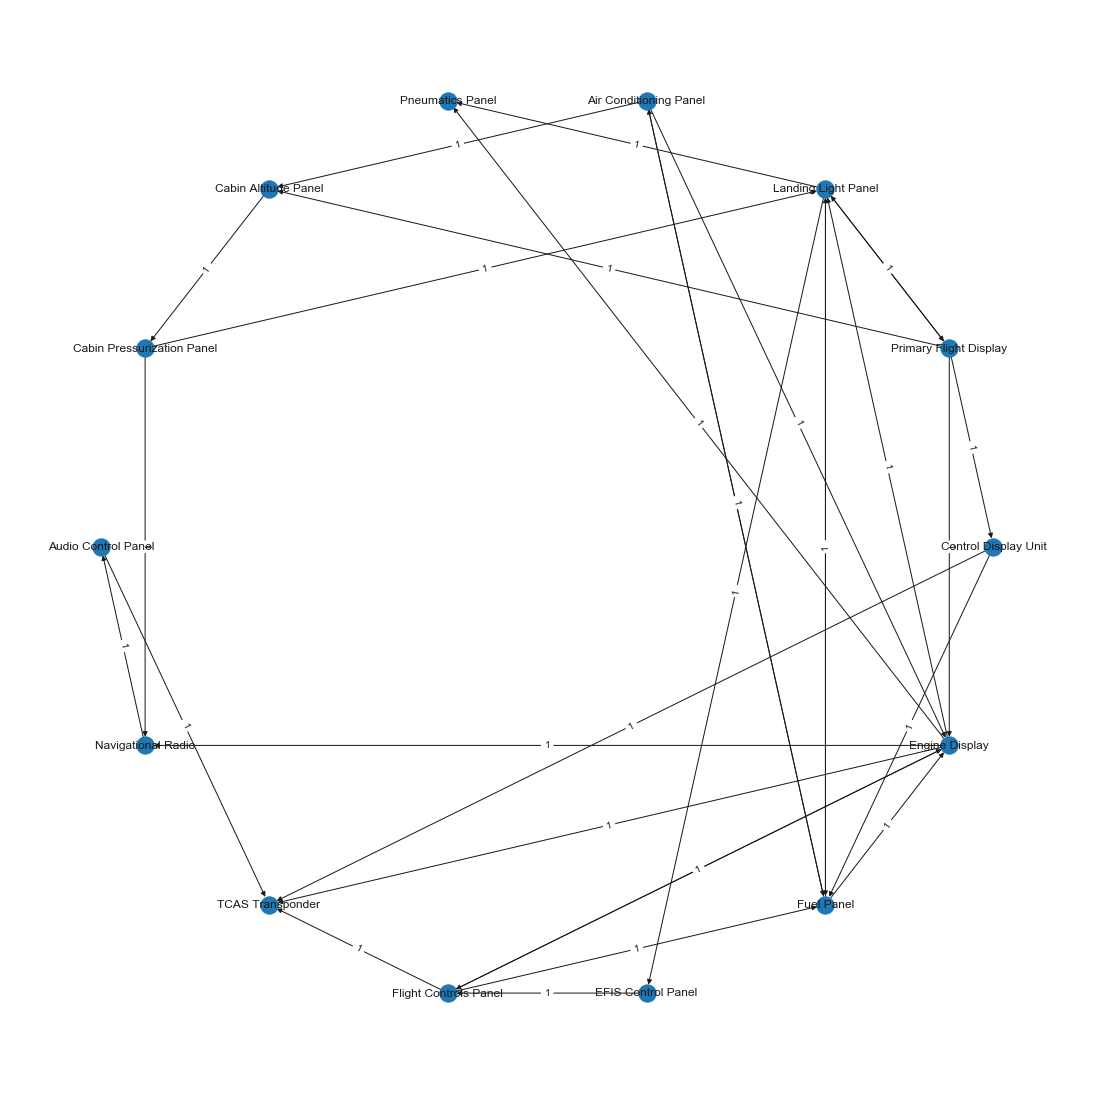

In [36]:
## Drawing full directed graph - one large diagram
## ALl nodes are connected according to sequence only
ds = dropProdCol(ds)
drawFullDetailedDirectedGraphs(ds)

In [37]:
def entireGraph_Undirected(dataFrame):
    counter = 1
    lastUsed = 0
    tempGraph = nx.Graph()
    tempGraph.add_nodes_from(dataFrame.columns)
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        for i in range(1, size+1):
            iterator = frames[frames == counter].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, counter)
                if counter != 1:
                    tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()

In [38]:
def entireGraph_Directed(dataFrame):
    counter = 1
    lastUsed = 0
    tempGraph = nx.DiGraph()
    tempGraph.add_nodes_from(dataFrame.columns)
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        for i in range(1, size+1):
            iterator = frames[frames == counter].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, counter)
                if counter != 1:
                    tempGraph.add_edge(lastUsed, res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    tempGraph.add_edge(lastUsed, iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()

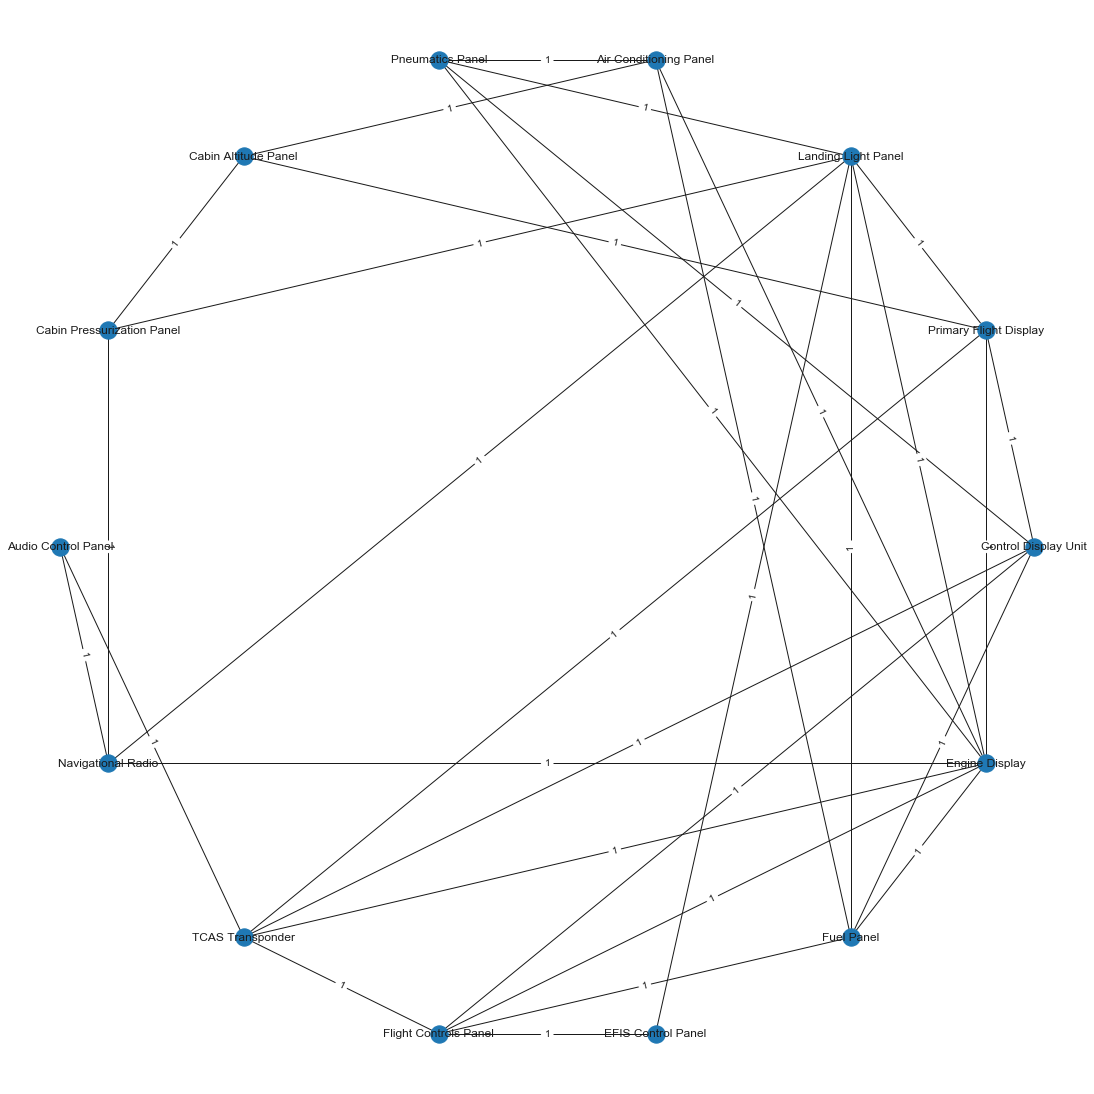

In [39]:
## Draw the entire graph with the procedures interconnected
## Undirected
ess = dropProdCol(ess)
entireGraph_Undirected(ess)

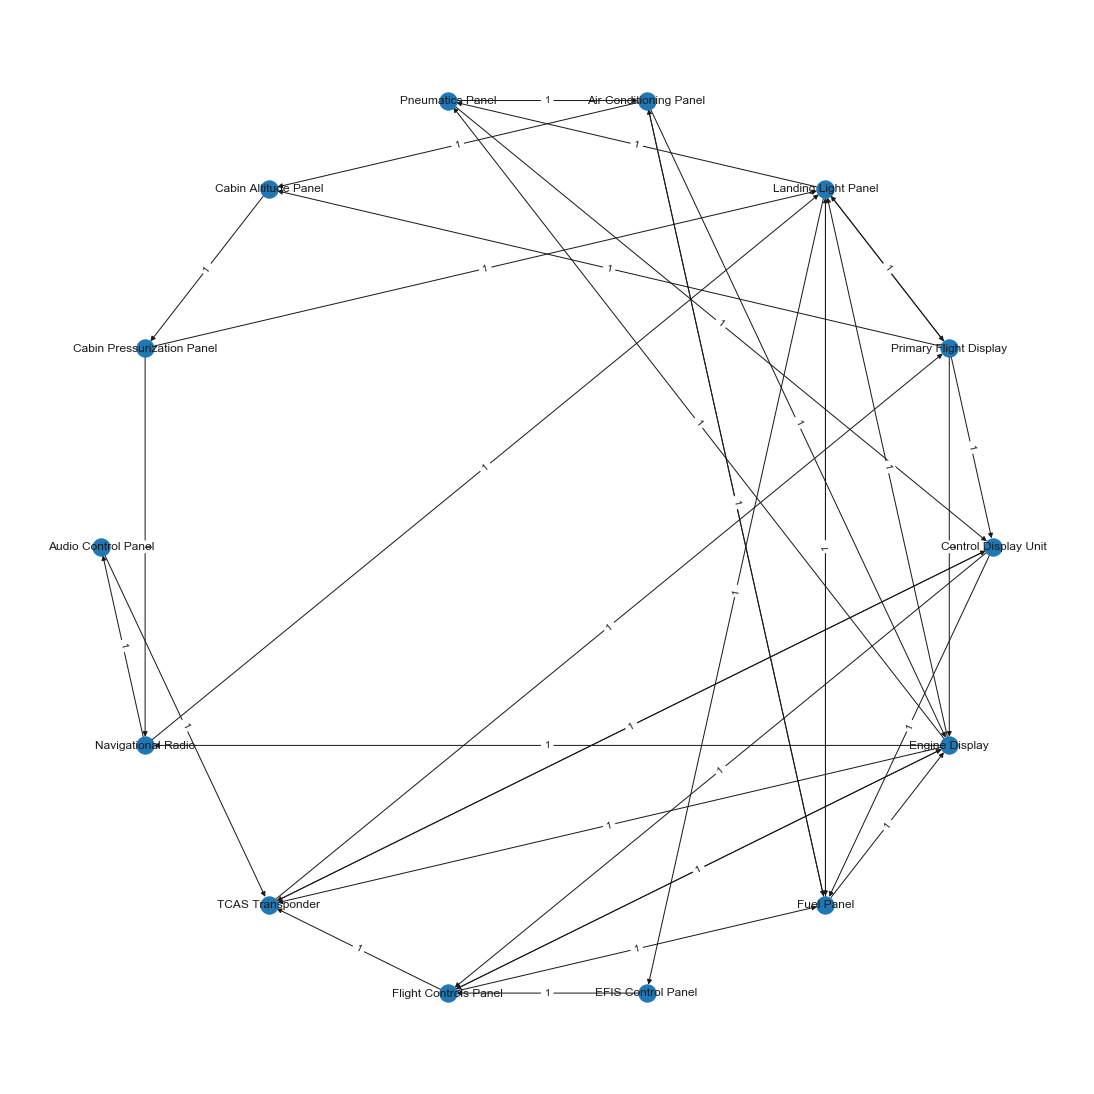

In [40]:
## Draw the entire graph with the procedures interconnected
## Directed
ess = dropProdCol(ess)
entireGraph_Directed(ess)

In [41]:
def graphTransformation(df):
    totals = []
    for col in df.columns.values:
        if(col != 'Quality'):
            totals.append(sum(df[col]))
    transformationGraph = pd.DataFrame(columns=df.columns)
    transformationGraph = transformationGraph.drop(columns=['Quality'])
    ## New list of names
    newNameList = []
    for colName in transformationGraph.columns.values:
        newNameList.append(colName+'_2')
    transformationGraph.columns = newNameList
    tot = pd.Series(totals, index=transformationGraph.columns)
    transformationGraph = transformationGraph.append(tot, ignore_index=True)
    return transformationGraph

In [42]:
def entireGraph_Directed_withWeights(dataFrame, transformationDf):
    counter = 1
    lastUsed = 0
    transDataFrame = graphTransformation(transformationDf)
    tempGraph = nx.DiGraph()
    nodeList = dataFrame.columns.values.tolist()+transDataFrame.columns.values.tolist()
    nodeList.sort()
    tempGraph.add_nodes_from(nodeList)
    ## tying them together
    for col in dataFrame.columns:
        tempGraph.add_edge(col, col+'_2', weight=transDataFrame.iloc[0][col+'_2'])
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        for i in range(1, size+1):
            iterator = frames[frames == counter].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, counter)
                if counter != 1:
                    if res != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    if iterator[0] != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()
    return tempGraph

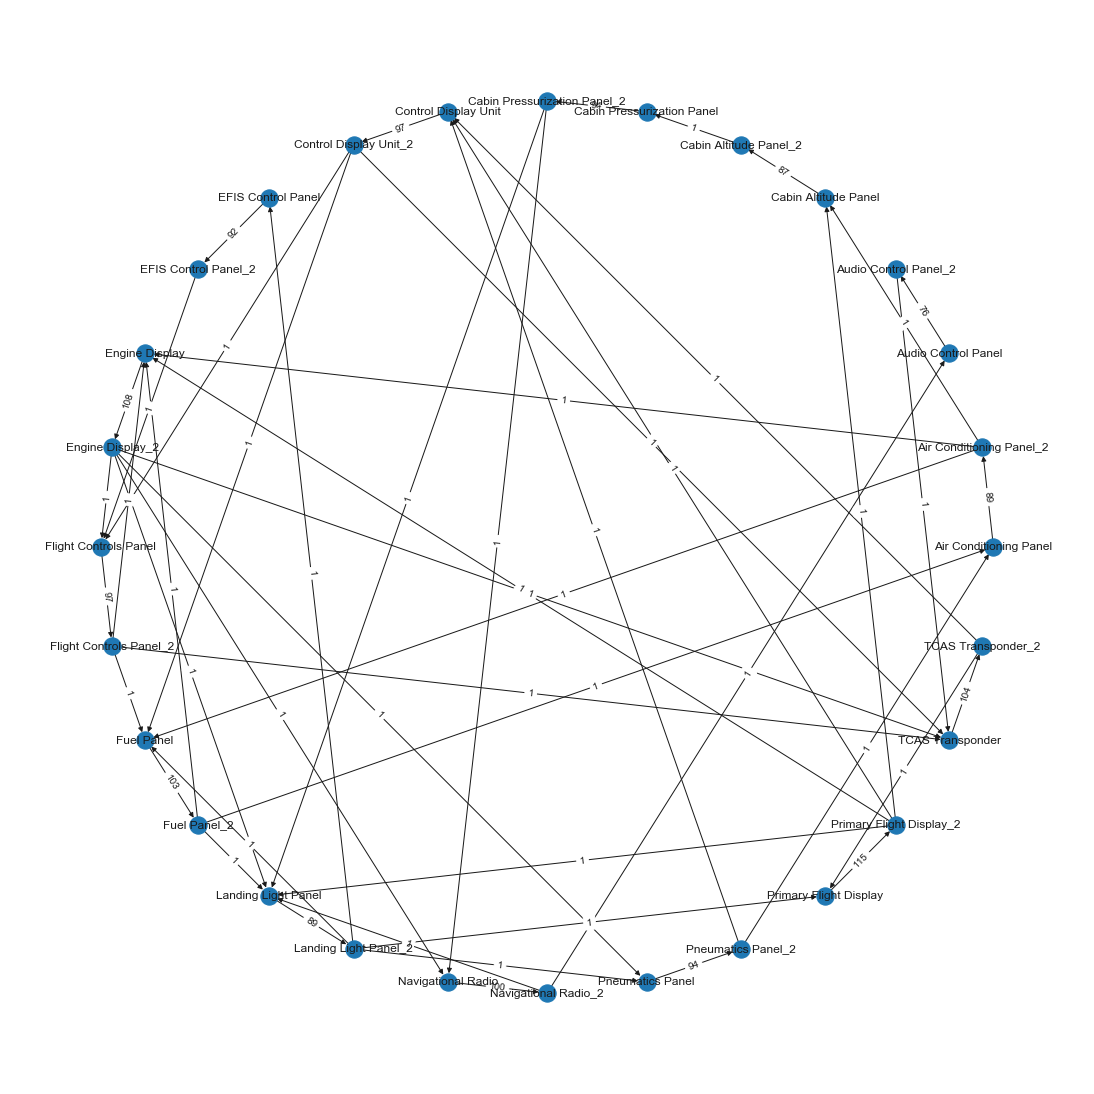

In [43]:
## Draw the entire graph with the procedures interconnected
## Directed
ess = dropProdCol(ess)
fullGraph_Directed_withWeights = entireGraph_Directed_withWeights(ess, df)

In [44]:
def drawFullDetailedDirectedGraphs_withWeights(dataFrame, transformationDf):
    counter = 1
    lastUsed = 0
    transDataFrame = graphTransformation(transformationDf)
    tempGraph = nx.DiGraph()
    nodeList = dataFrame.columns.values.tolist()+transDataFrame.columns.values.tolist()
    nodeList.sort()
    tempGraph.add_nodes_from(nodeList)
    ## tying them together
    for col in dataFrame.columns:
        tempGraph.add_edge(col, col+'_2', weight=transDataFrame.iloc[0][col+'_2'])
    for index in dataFrame.index.values:
        frames = dataFrame.iloc[index]
        frames = frames.drop_duplicates(keep=False)
        size = getSize(frames)
        lastUsed = getFirst(frames)
        for i in range(1, size+1):
            iterator = frames[frames == i].index.values
            if len(iterator) == 0:
                res = findIndexUsingNum(frames, i)
                if counter != 1:
                    if res != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', res, weight=1)
                lastUsed = res
                counter +=1
            else:
                if counter != 1:
                    if iterator[0] != lastUsed:
                        tempGraph.add_edge(lastUsed+'_2', iterator[0], weight=1)
                lastUsed = iterator[0]
                counter +=1
    plt.rcParams['figure.figsize'] = [15, 15]
    nx.draw_circular(tempGraph, with_labels=True)
    labels = nx.get_edge_attributes(tempGraph,'weight')
    nx.draw_networkx_edge_labels(tempGraph,pos=nx.circular_layout(tempGraph),edge_labels=labels)
    plt.draw()
    plt.show()
    return tempGraph

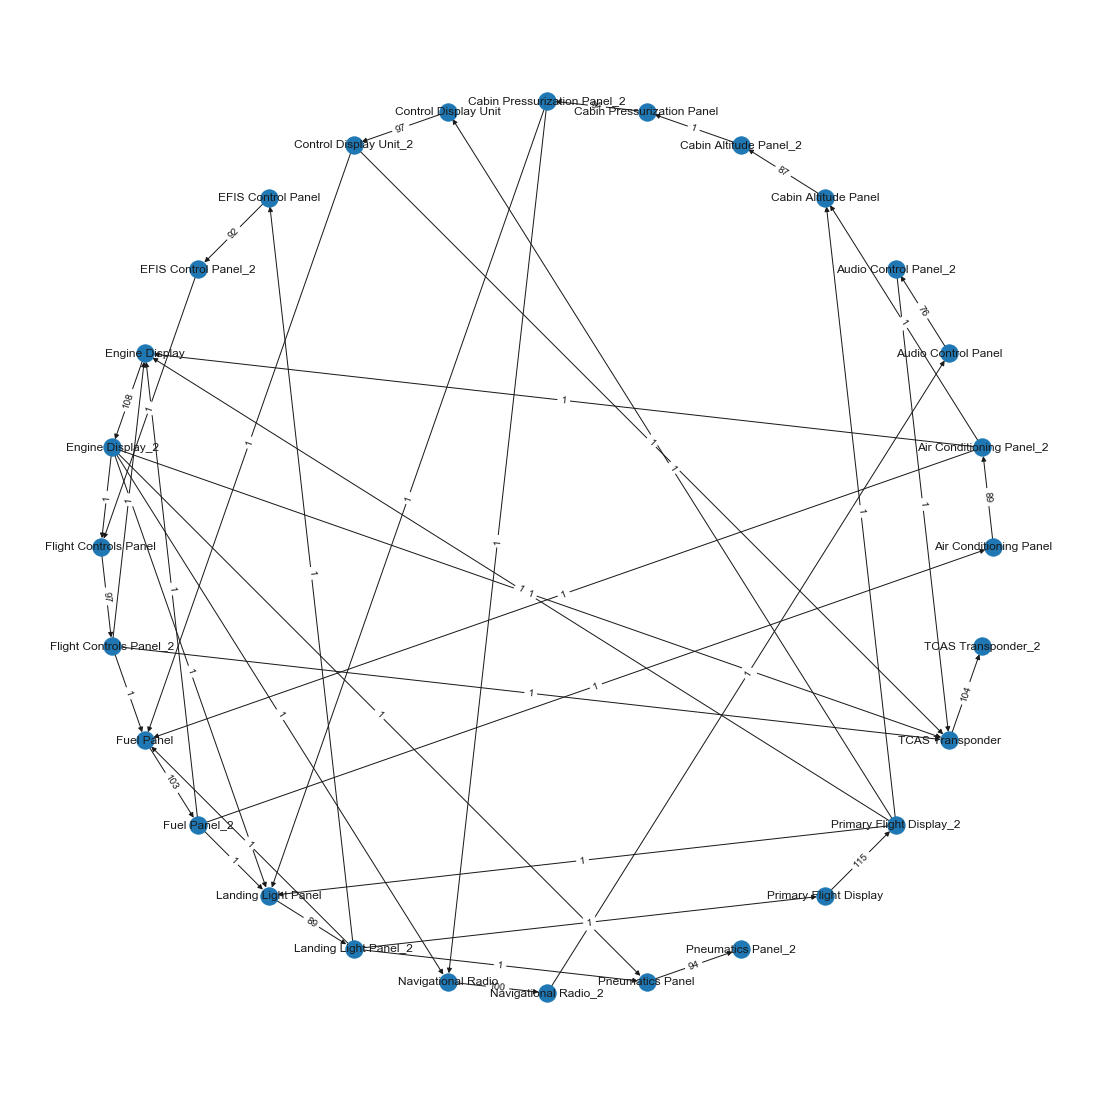

In [45]:
## Drawing full directed graph with weights- one large diagram
## ALl nodes are connected according to sequence only
ds = dropProdCol(ds)
procedureOnly_DirectedGraph_Full_Weighted = drawFullDetailedDirectedGraphs_withWeights(ds, df)

In [46]:
def getCleanList_Tuple(dirtyTupleList):
    cleanList = []
    for item in dirtyTupleList:
        (val1, val2) = item
        if "2" not in val1 and val1 not in cleanList:
            cleanList.append(val1)
        if "2" not in val2 and val2 not in cleanList:
            cleanList.append(val2)
    return cleanList

In [47]:
def getFirstAsSource(dataFrame):
    answer = dataFrame.iloc[0]
    ans = answer[answer == 1].index[0]
    return ans

In [48]:
## Depth First search on procedural only, directed graph, full
dfs_tree_procedureOnly_DirectedGraph_Full_Weighted = nx.dfs_edges(procedureOnly_DirectedGraph_Full_Weighted, source=getFirstAsSource(ess))
clean_dfs_list_procedureOnly_DirectedGraph_Full_Weighted = getCleanList_Tuple(list(dfs_tree_procedureOnly_DirectedGraph_Full_Weighted))

In [49]:
## Breath First search on procedural only, directed graph, full
bfs_tree_procedureOnly_DirectedGraph_Full_Weighted = nx.bfs_edges(procedureOnly_DirectedGraph_Full_Weighted, source=getFirstAsSource(ess))
clean_bfs_list_procedureOnly_DirectedGraph_Full_Weighted = getCleanList_Tuple(list(bfs_tree_procedureOnly_DirectedGraph_Full_Weighted))

In [50]:
## Depth First search on start to finish, directed graph, full
dfs_tree_fullGraph_Directed_withWeights = nx.dfs_edges(fullGraph_Directed_withWeights, source=getFirstAsSource(ess))
clean_dfs_list_fullGraph_Directed_withWeights = getCleanList_Tuple(list(dfs_tree_fullGraph_Directed_withWeights))

In [51]:
## Breath First search on start to finish, directed graph, full
bfs_tree_fullGraph_Directed_withWeights = nx.dfs_edges(fullGraph_Directed_withWeights, source=getFirstAsSource(ess))
clean_bfs_list_fullGraph_Directed_withWeights = getCleanList_Tuple(list(bfs_tree_fullGraph_Directed_withWeights))

In [52]:
## Creating pandas dataframe: 1 row for each insturment with the following parameters;
# Name,TotalAttributes,ProceduralUse,Height,Width
# 4 columns added later for points AboveRight,AboveLeft,UnderRight,UnderLeft
def dataFrameCreation(pd, df):
    instFrame = pd.DataFrame(columns=['Name', 'TotalAttributes',
                                      'ProceduralUse', 'Height',
                                      'Width', 'AboveRight',
                                      'AboveLeft','UnderRight',
                                      'UnderLeft', 'Colour'])
    columnList = df.columns.values.tolist()
    columnList.remove('Quality')
    for inst in columnList:
        instFrame = instFrame.append({'Name': inst, 'TotalAttributes': df[inst].sum(),
                                      'ProceduralUse': pf[inst].sum(),
                                      'Height':ss.loc[ss.Instrument == inst]['Height'].values[0],
                                      'Width' :ss.loc[ss.Instrument == inst]['Width'].values[0],
                                     'AboveRight': 0,
                                     'AboveLeft': 0,
                                     'UnderRight': 0,
                                     'UnderLeft': 0},
                                     ignore_index=True)
    return instFrame

In [53]:
## Generate Colours
def colGen():
    ## 100 colours
    colourList = []
    for i in range (100):
        colour = (randint(99,255)/255.0,randint(99,255)/255.0,randint(99,255)/255.0)
        while colour not in colourList:
            colour = (randint(99,255)/255.0,randint(99,255)/255.0,randint(99,255)/255.0)
            colourList.append(colour)
    return colourList

In [54]:
## Colour Picker
def colPick(canvas):
    colourList = canvas.getColList()
    picked = random.choice(colourList)
    colourList.remove(picked)
    canvas.setColList(colourList)
    return picked

In [55]:
## Art Canvas ##
class Canvas:
    
    def __init__(self):
        self.colourList = []
        self.paintWidth = 1700
        self.paintHeight = 2600
        self.ims = cairo.ImageSurface(cairo.FORMAT_ARGB32, self.paintWidth, self.paintHeight)
        self.cr = cairo.Context(self.ims)
    
    def getCanvasWidth(self):
        return self.paintWidth
    
    def getCanvasHeight(self):
        return self.paintHeight
    
    def getCr(self):
        return self.cr
    
    def setColList(self, colList):
        self.colourList = colList
        
    def getColList(self):
        return self.colourList

In [56]:
class Store():
       
    def __init__(self):
        self.PointListCovered = set()
        self.AllowedList = set()
        self.UserLocation = 0
        self.differenceStorage = 0
        self.Separators = []
    
    def getPointList(self):
        return self.PointListCovered
    
    def setPointList(self, newList):
        self.PointListCovered = newList
        
    def getAllowedList(self):
        return self.AllowedList
    
    def setAllowedList(self, newList):
        self.AllowedList = newList
        
    def getUserLocation(self):
        return self.UserLocation
    
    def setUserLocation(self, newCo):
        self.UserLocation = newCo
        
    def getDifference(self):
        return self.differenceStorage
    
    def setDifference(self, diff):
        self.differenceStorage = diff
        
    def getSeparators(self):
        return self.Separators
    
    def setSeparators(self, new):
        self.Separators = new

In [57]:
## Store all points used and save
## The +1 was added because of iterator range stopping short of the last coordinate
def pointStorage(bottomLeft, bottomRight, topLeft, topRight, storage):
    PointListCovered = storage.getPointList()
    (bottomLeftX, bottomLeftY) = bottomLeft
    (bottomRightX, bottomRightY) = bottomRight
    (topLeftX, topLeftY) = topLeft
    (topRightX, topRightY) = topRight
    for i in range(topLeftX, topRightX+1):
        for y in range(topRightY, bottomRightY+1):
            PointListCovered.add(Point(i, y))
    storage.setPointList(PointListCovered)

In [58]:
## Store canvas area which is allowed to be used
## The +1 was added because of iterator range stopping short of the last coordinate
def canvasAllowed(bottomLeft, bottomRight, topLeft, topRight, storage):
    separators = storage.getSeparators()
    tempSet = set()
    canvasCovered = storage.getAllowedList()
    (bottomLeftX, bottomLeftY) = bottomLeft
    (bottomRightX, bottomRightY) = bottomRight
    (topLeftX, topLeftY) = topLeft
    (topRightX, topRightY) = topRight
    for i in range(topLeftX, topRightX+1):
        for y in range(topRightY, bottomRightY+1):
            canvasCovered.add(Point(i, y))
            tempSet.add(Point(i,y))
    separators.append(tempSet)
    storage.setSeparators(separators)
    storage.setAllowedList(canvasCovered)

In [59]:
def sepCheck(bottomLeft, bottomRight, topLeft, topRight, storage):
    separators = storage.getSeparators()
    for sepSet in separators:
        if bottomLeft in sepSet and bottomRight in sepSet and topLeft in sepSet and topRight in sepSet:
            return True
    return False

In [60]:
# Find me a point in which this insturment can fit in
def coCycle(width, height, storage):
    diffStore = storage.getDifference()
    # Iterate over every row
    for index, row in diffStore.iterrows():
        x = int(row['X'])
        y = int(row['Y'])
        if Point(x,y) not in storage.getPointList():
            ## Pick direction at random
            randomPoint = [0, 1, 2, 3]
            random.shuffle(randomPoint)
            for i in randomPoint:
                if i == 0:
                    ## NE
                    bottomLeft = Point(x,y)
                    bottomRight = Point(x+width,y)
                    topLeft = Point(x,y-height)
                    topRight = Point(x+width,y-height)
                    
                    if (bottomLeft not in storage.getPointList() and bottomRight not in storage.getPointList() and topLeft not in storage.getPointList() and topRight not in storage.getPointList()
                    and bottomLeft in storage.getAllowedList() and bottomRight in storage.getAllowedList() and topLeft in storage.getAllowedList() and topRight in storage.getAllowedList()
                       and sepCheck(bottomLeft,bottomRight,topLeft,topRight,storage) == True):
                        return bottomLeft, bottomRight, topLeft, topRight
                if i == 1:
                    ## NW
                    bottomLeft = Point(x-width,y)
                    bottomRight = Point(x,y)
                    topLeft = Point(x-width,y-height)
                    topRight = Point(x,y-height)
                    
                    if (bottomLeft not in storage.getPointList() and bottomRight not in storage.getPointList() and topLeft not in storage.getPointList() and topRight not in storage.getPointList()
                    and bottomLeft in storage.getAllowedList() and bottomRight in storage.getAllowedList() and topLeft in storage.getAllowedList() and topRight in storage.getAllowedList()
                       and sepCheck(bottomLeft,bottomRight,topLeft,topRight,storage) == True):
                        return bottomLeft, bottomRight, topLeft, topRight
                if i == 2:
                    ## SW
                    bottomLeft = Point(x-width,y+height)
                    bottomRight = Point(x,y+height)
                    topLeft = Point(x-width,y)
                    topRight = Point(x,y)
                    
                    if (bottomLeft not in storage.getPointList() and bottomRight not in storage.getPointList() and topLeft not in storage.getPointList() and topRight not in storage.getPointList()
                        and bottomLeft in storage.getAllowedList() and bottomRight in storage.getAllowedList() and topLeft in storage.getAllowedList() and topRight in storage.getAllowedList()
                       and sepCheck(bottomLeft,bottomRight,topLeft,topRight,storage) == True):
                        return bottomLeft, bottomRight, topLeft, topRight
                if i == 3:
                    ## SE
                    bottomLeft = Point(x,y+height)
                    bottomRight = Point(x+width,y+height)
                    topLeft = Point(x,y)
                    topRight = Point(x+width,y)
                    
                    if (bottomLeft not in storage.getPointList() and bottomRight not in storage.getPointList() and topLeft not in storage.getPointList() and topRight not in storage.getPointList() 
                        and bottomLeft in storage.getAllowedList() and bottomRight in storage.getAllowedList() and topLeft in storage.getAllowedList() and topRight in storage.getAllowedList()
                       and sepCheck(bottomLeft,bottomRight,topLeft,topRight,storage) == True):
                        return bottomLeft, bottomRight, topLeft, topRight

In [61]:
## Method to reset coordinates for redrawn
def resetCO(instFrame):
    for index in instFrame.index:
        instFrame.at[index, 'UnderLeft'] = 0
        instFrame.at[index, 'UnderRight'] = 0
        instFrame.at[index, 'AboveLeft'] = 0
        instFrame.at[index, 'AboveRight'] = 0
    return instFrame

In [62]:
## Legend Artist
def legendDraw(instFrame):
    ## Create canvas
    ims = cairo.ImageSurface(cairo.FORMAT_ARGB32, 2000, 2000)
    cr = cairo.Context(ims)
    x1 = 1000
    y1 = 500
    x2 = 1200
    x3 = 1250
    for index in instFrame.index:
        tempFrame = instFrame.loc[[index]]
        (r,g,b) = tempFrame['Colour'].values[0]
        cr.set_source_rgb(r,g,b)
        cr.move_to(x1,y1)
        cr.line_to(x2,y1)
        cr.set_line_width(19)
        cr.stroke()
        cr.move_to(x3,y1)
        cr.set_source_rgb(0, 0, 0)
        cr.set_font_size(25)
        cr.select_font_face("Arial",
                     cairo.FONT_SLANT_NORMAL,
                     cairo.FONT_WEIGHT_BOLD)
        cr.show_text(tempFrame.Name.values[0])
        y1 = y1 + 100
    ims.write_to_png('Legend.png')

In [63]:
## This has to be custom made to fit
def drawCockpitCanvas(canvas, storage):
    cr = canvas.getCr()
    cr.set_source_rgb(0, 0, 0)
    # forward and aft overhead panel
    cr.move_to(550, 0)
    cr.line_to(1220,0)
    cr.line_to(1220,1045)
    cr.line_to(550,1045)
    cr.line_to(550,0)
    cr.close_path()
    cr.set_source_rgb(0,0,0)
    cr.set_line_width(7)
    cr.stroke()
    ## bottom left - bottom right- top left - top right
    canvasAllowed(Point(550,1045), Point(1220,1045), Point(550,0), Point(1220,0), storage)
    # glareshield
    cr.move_to(550,1046)
    cr.line_to(427,1046)
    cr.line_to(427,1121)
    cr.line_to(1342,1121)
    cr.line_to(1342,1046)
    cr.line_to(550,1046)
    cr.set_source_rgb(0, 0, 0)
    cr.set_line_width(7)
    cr.stroke()
    canvasAllowed(Point(427,1121), Point(1342,1121), Point(427,1046), Point(1342,1046), storage)
    # main panel - top
    cr.move_to(427,1122)
    cr.line_to(127,1122)
    cr.line_to(127,1567)
    cr.line_to(1642,1567)
    cr.line_to(1642,1122)
    cr.line_to(427,1122)
    cr.set_source_rgb(0, 0, 0)
    cr.set_line_width(7)
    cr.stroke()
    canvasAllowed(Point(127,1567), Point(1642,1567), Point(127,1122), Point(1642,1122), storage)
    # main panel - low
    cr.move_to(627,1568)
    cr.line_to(627,1703)
    cr.line_to(1142,1703)
    cr.line_to(1142,1568)
    cr.line_to(627,1568)
    cr.set_source_rgb(0, 0, 0)
    cr.set_line_width(7)
    cr.stroke()
    canvasAllowed(Point(627,1703), Point(1142,1703), Point(627,1568), Point(1142,1703), storage)
    # throttle quadrant
    cr.move_to(988,1704)
    cr.line_to(781,1704)
    cr.line_to(781,1942)
    cr.line_to(988, 1942)
    cr.line_to(988, 1704)
    cr.set_source_rgb(0, 0, 0)
    cr.set_line_width(7)
    cr.stroke()
    # NOTHING IS TO TAKE THE SPACE USED BY PHYSICAL CONTROL INSTURMENTS
    #canvasAllowed(Point(781,1942), Point(988,1942), Point(781,1704), Point(988,1704), storage)
    # pedestal
    cr.move_to(1112,1943)
    cr.line_to(1112,2506)
    cr.line_to(657,2506)
    cr.line_to(657,1943)
    cr.line_to(1112,1943)
    cr.set_source_rgb(0, 0, 0)
    cr.set_line_width(7)
    cr.stroke()
    canvasAllowed(Point(657,2506), Point(1112,2506), Point(657,1943), Point(1112,1943), storage)
    ## Place Captain and First Officer
    ## Captain 
    midpointCx = int(math.floor((657+127)/2))
    midpointCy = int(math.floor((2506+1122)/2))
    cr.arc(midpointCx, midpointCy, 100, 0, 2*math.pi)
    cr.close_path()
    cr.set_source_rgb(0,0,0)
    cr.set_line_width(7)
    cr.stroke()
    storage.setUserLocation(Point(midpointCx,midpointCy))
    ## First Officer
    midpointCx = int(math.floor((1112+1642)/2))
    midpointCy = int(math.floor((2506+1122)/2))
    cr.arc(midpointCx, midpointCy, 100, 0, 2*math.pi)
    cr.close_path()
    cr.set_source_rgb(0,0,0)
    cr.set_line_width(7)
    cr.stroke()

In [64]:
## Distance Formula
def distFormula(series, user):
    (x2, y2) = user
    x = math.pow(x2-series['X'],2)
    y = math.pow(y2-series['Y'],2)
    return math.sqrt(x+y)

In [65]:
## Method which calculates the distance between the pilots and the point
def distCalc(storage):
    diffPd = pd.DataFrame(storage.getAllowedList(), columns=['X', 'Y'])
    userLoc = storage.getUserLocation()
    diffPd['Difference'] = diffPd.apply(distFormula, axis=1, user=userLoc)
    diffPd = diffPd.sort_values(by=['Difference'], ascending=True)
    storage.setDifference(diffPd)      

In [66]:
def newArtist(toDraw, instFrame, singleFrame, canvas, storage):
    #print("CALLED TO DRAW: ", instrument.index.values[0])
    cr = canvas.getCr()
    
    (bottomLeft, bottomRight, topLeft, topRight) = toDraw
    
    ## Store the coordinates in the pandas dataframe original
    instFrame.at[singleFrame.index.values[0], 'UnderLeft'] = bottomLeft
    instFrame.at[singleFrame.index.values[0], 'UnderRight'] = bottomRight
    instFrame.at[singleFrame.index.values[0], 'AboveLeft'] = topLeft
    instFrame.at[singleFrame.index.values[0], 'AboveRight'] = topRight
    
    ## Store the tuples to be covered
    pointStorage(bottomLeft, bottomRight, topLeft, topRight, storage)
    ## Now to draw
    (x1,y1) = bottomLeft
    (x2,y2) = bottomRight
    (x3,y3) = topLeft
    (x4,y4) = topRight
    
    cr.move_to(x1,y1)
    cr.line_to(x2,y2)
    cr.line_to(x4,y4)
    cr.line_to(x3,y3)
    cr.line_to(x1,y1)
    cr.close_path()
    
    if singleFrame['Colour'].isnull().values:
        (r,g,b) = colPick(canvas)
        instFrame.at[singleFrame.index.values[0], 'Colour'] = (r,g,b)
    else:
        (r,g,b) = singleFrame['Colour'].values[0]
    cr.set_source_rgb(r,g,b)
    cr.fill_preserve()
    cr.stroke()
    
    return instFrame

In [67]:
def locationMain(indexNumber, allFrames, canvas, storage):
    ## Take width and height
    tempFrame = allFrames.loc[[indexNumber]]
    ## Call method to find the point which can be used
    points = coCycle(int(tempFrame['Width']), int(tempFrame['Height']), storage)
    modifiedFrame = newArtist(points, allFrames, tempFrame, canvas, storage)
    return modifiedFrame

In [68]:
## Main Method Algorithm ##
instFrame = dataFrameCreation(pd, df)
instFrame = instFrame.sort_values(by=['ProceduralUse'], ascending=False)
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    drawCockpitCanvas(canvas, storage)
    distCalc(storage)    
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = locationMain(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
        
    canvas.ims.write_to_png('Normal_Procedural_'+str(x)+'.png')
legendDraw(instFrame)

In [69]:
## Sorted - full directed graph from procedure only BFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_bfs_list_procedureOnly_DirectedGraph_Full_Weighted)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    drawCockpitCanvas(canvas, storage)
    distCalc(storage)    
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = locationMain(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('Procedural_Full_Weighted_BFS_'+str(x)+'.png')
legendDraw(instFrame)

In [70]:
## Sorted - full directed graph from procedure only DFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_dfs_list_procedureOnly_DirectedGraph_Full_Weighted)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    drawCockpitCanvas(canvas, storage)
    distCalc(storage)    
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = locationMain(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('Procedural_Weighted_DFS_'+str(x)+'.png')
legendDraw(instFrame)

In [71]:
## Sorted - full directed graph from start to finish BFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_bfs_list_fullGraph_Directed_withWeights)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    drawCockpitCanvas(canvas, storage)
    distCalc(storage)    
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = locationMain(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('SF_Full_Weighted_BFS_'+str(x)+'.png')
legendDraw(instFrame)

In [72]:
## Sorted - full directed graph from start to finish DFS version
instFrame['Name'] = pd.Categorical(instFrame['Name'], clean_dfs_list_fullGraph_Directed_withWeights)
instFrame = instFrame.sort_values('Name')
for x in range(20):
    canvas = Canvas()
    storage = Store()
    canvas.setColList(colGen())
    instFrame = resetCO(instFrame)
    drawCockpitCanvas(canvas, storage)
    distCalc(storage)    
    for index in instFrame.index:
        ## Call method which is to take the instrument and draw it
        #print("Main method - Instrument picked to draw: ", index)
        modifiedFrame = locationMain(index, instFrame, canvas, storage)
        instFrame = modifiedFrame
    canvas.ims.write_to_png('SF_Full_Weighted_DFS_'+str(x)+'.png')
legendDraw(instFrame)